In [4]:
import matplotlib.pyplot as plt
import seaborn as sns



In [1]:
import pandas as pd
import numpy as np

# Load the data
df = pd.read_csv('OneDrive_1_2025-6-11/data/plcgtfs-20240101.csv', skiprows=1)

# Translate column names
translations = {
    'Tag': 'Date',
    'Kurzbezeichnung': 'ShortName',
    'ZugNr': 'TrainNumber',
    'FahrtNr': 'TripNumber',
    'FahrtArt': 'TripType',
    'FahrtStartSekunden': 'TripStartSeconds',
    'FahrtEndeSekunden': 'TripEndSeconds',
    'FahrtStart': 'TripStart',
    'FahrtEnde': 'TripEnd',
    'LinienNr': 'LineNumber',
    'LinienRichtungText': 'LineDirection',
    'AnkunftSekunden': 'ArrivalSeconds',
    'AbfahrtSekunden': 'DepartureSeconds',
    'Ein1Klasse': 'Board1stClass',
    'Aus1Klasse': 'Alight1stClass',
    'Belegung1Klasse': 'Occupancy1stClass',
    'Ein2Klasse': 'Board2ndClass',
    'Aus2Klasse': 'Alight2ndClass',
    'Belegung2Klasse': 'Occupancy2ndClass',
    'DistanzMeter': 'DistanceMeters',
    'Kurzbezeichnung1': 'StationCode',
    'DidokNr': 'StationID'
}
df.rename(columns=translations, inplace=True)

print("=== Basic Data Information ===")
print(f"Total Rows: {len(df):,}")
print(f"Number of Lines: {df['LineNumber'].nunique()}")
print(f"Number of Trips: {df['TripNumber'].nunique()}")
print(f"Number of Stations: {df['StationID'].nunique()}")

# Data cleaning and preparation
print("\n=== Data Cleaning ===")
df_clean = df.dropna(subset=['ArrivalSeconds', 'DepartureSeconds'])
print(f"Rows after cleaning: {len(df_clean):,}")

# Fix time format (European format: day.month.year)
df_clean['Date'] = pd.to_datetime(df_clean['Date'], format='%d.%m.%Y %H:%M:%S')
df_clean['TripStart'] = pd.to_datetime(df_clean['TripStart'], format='%d/%m/%Y %H:%M:%S')
df_clean['TripEnd'] = pd.to_datetime(df_clean['TripEnd'], format='%d/%m/%Y %H:%M:%S')
print(f"Date Range: {df_clean['Date'].min()} to {df_clean['Date'].max()}")

# Calculate delay time
df_clean['DelaySeconds'] = df_clean['ArrivalSeconds'] - df_clean['TripStartSeconds']

print("\n=== On-Time Performance Analysis ===")
# On-time threshold (¬±2 minutes)
on_time_threshold = 120
df_clean['OnTime'] = (abs(df_clean['DelaySeconds']) <= on_time_threshold)

# Overall on-time rate
overall_on_time = df_clean['OnTime'].mean() * 100
print(f"Overall On-Time Rate: {overall_on_time:.1f}%")

# Delay statistics
print(f"Average Delay: {df_clean['DelaySeconds'].mean():.1f} seconds")
print(f"Median Delay: {df_clean['DelaySeconds'].median():.1f} seconds")

print("\n=== On-Time Rate by Line ===")
line_stats = df_clean.groupby('LineNumber').agg({
    'OnTime': 'mean',
    'DelaySeconds': 'mean',
    'TripNumber': 'count'
}).round(3)
line_stats['On-Time Rate %'] = line_stats['OnTime'] * 100
line_stats = line_stats.rename(columns={'TripNumber': 'Records', 'DelaySeconds': 'AvgDelaySeconds'})

print("Top 5 Lines by On-Time Rate:")
print(line_stats.sort_values('On-Time Rate %', ascending=False).head())
print("\nBottom 5 Lines by On-Time Rate:")
print(line_stats.sort_values('On-Time Rate %', ascending=True).head())

print("\n=== Time of Day Analysis ===")
df_clean['Hour'] = df_clean['TripStart'].dt.hour
hourly_stats = df_clean.groupby('Hour')['OnTime'].mean() * 100
print("On-Time Rate by Hour:")
for hour, rate in hourly_stats.items():
    print(f"{hour:2d}h: {rate:.1f}%")

print("\n=== Passenger Flow Analysis ===")
df_clean['TotalBoarding'] = df_clean['Board1stClass'] + df_clean['Board2ndClass']
df_clean['TotalOccupancy'] = df_clean['Occupancy1stClass'] + df_clean['Occupancy2ndClass']
print(f"Average Boarding Count: {df_clean['TotalBoarding'].mean():.1f}")
print(f"Average Occupancy: {df_clean['TotalOccupancy'].mean():.1f}")

# On-time rate by occupancy level
high_occupancy = df_clean['TotalOccupancy'] > df_clean['TotalOccupancy'].median()
print(f"High Occupancy Trips On-Time Rate: {df_clean[high_occupancy]['OnTime'].mean()*100:.1f}%")
print(f"Low Occupancy Trips On-Time Rate: {df_clean[~high_occupancy]['OnTime'].mean()*100:.1f}%")

# ==================== New: High Delay Rate Analysis ====================

print("\n" + "="*50)
print("=== High Delay Rate Lines Analysis ===")
print("="*50)

# Filter lines with sufficient data (at least 100 records)
min_records = 100
sufficient_data_lines = line_stats[line_stats['Records'] >= min_records]

# Lines with highest delay rates (lowest on-time rates)
high_delay_lines = sufficient_data_lines.sort_values('On-Time Rate %', ascending=True)

print(f"\nTop 10 Lines with Highest Delay Rate (records ‚â• {min_records}):")
print("-" * 60)
print(f"{'Line':<8} {'On-Time %':<10} {'Avg Delay (s)':<15} {'Records':<10}")
print("-" * 60)

for idx, (line_num, row) in enumerate(high_delay_lines.head(10).iterrows()):
    delay_rate = 100 - row['On-Time Rate %']
    print(f"{line_num:<8} {row['On-Time Rate %']:<10.1f} {row['AvgDelaySeconds']:<15.1f} {row['Records']:<10.0f}")

# Severely delayed lines (on-time rate < 70%)
severely_delayed_lines = sufficient_data_lines[sufficient_data_lines['On-Time Rate %'] < 70]
if len(severely_delayed_lines) > 0:
    print(f"\nSeverely Delayed Lines (On-Time Rate < 70%):")
    print(f"Total: {len(severely_delayed_lines)} lines")
    for line_num, row in severely_delayed_lines.iterrows():
        print(f"Line {line_num}: On-Time Rate {row['On-Time Rate %']:.1f}%, Avg Delay {row['AvgDelaySeconds']:.0f}s")

print("\n" + "="*50)
print("=== High Delay Rate Stations Analysis ===")
print("="*50)

# Station-level delay analysis
station_stats = df_clean.groupby(['StationID', 'StationCode']).agg({
    'OnTime': 'mean',
    'DelaySeconds': 'mean',
    'TripNumber': 'count'
}).round(3)

station_stats['On-Time Rate %'] = station_stats['OnTime'] * 100
station_stats = station_stats.rename(columns={'TripNumber': 'Records', 'DelaySeconds': 'AvgDelaySeconds'})

# Filter stations with at least 50 records
min_station_records = 50
sufficient_data_stations = station_stats[station_stats['Records'] >= min_station_records]

# Stations with the highest delay rates
high_delay_stations = sufficient_data_stations.sort_values('On-Time Rate %', ascending=True)

print(f"\nTop 15 Stations with Highest Delay Rates (records ‚â• {min_station_records}):")
print("-" * 80)
print(f"{'Station Code':<12} {'Station ID':<12} {'On-Time %':<10} {'Avg Delay (s)':<15} {'Records':<10}")
print("-" * 80)

for idx, ((station_id, station_code), row) in enumerate(high_delay_stations.head(15).iterrows()):
    print(f"{station_code:<12} {station_id:<12} {row['On-Time Rate %']:<10.1f} {row['AvgDelaySeconds']:<15.1f} {row['Records']:<10.0f}")

# Severely delayed stations (on-time rate < 60%)
severely_delayed_stations = sufficient_data_stations[sufficient_data_stations['On-Time Rate %'] < 60]
if len(severely_delayed_stations) > 0:
    print(f"\nSeverely Delayed Stations (On-Time Rate < 60%):")
    print(f"Total: {len(severely_delayed_stations)} stations")
    for (station_id, station_code), row in severely_delayed_stations.iterrows():
        print(f"Station {station_code} (ID: {station_id}): On-Time Rate {row['On-Time Rate %']:.1f}%, Avg Delay {row['AvgDelaySeconds']:.0f}s")

print("\n" + "="*50)
print("=== Line-Station Delay Combination Analysis ===")
print("="*50)

# Line-station delay analysis
line_station_stats = df_clean.groupby(['LineNumber', 'StationCode']).agg({
    'OnTime': 'mean',
    'DelaySeconds': 'mean',
    'TripNumber': 'count'
}).round(3)

line_station_stats['On-Time Rate %'] = line_station_stats['OnTime'] * 100
line_station_stats = line_station_stats.rename(columns={'TripNumber': 'Records', 'DelaySeconds': 'AvgDelaySeconds'})

# Filter combinations with at least 20 records
min_combo_records = 20
sufficient_combo_data = line_station_stats[line_station_stats['Records'] >= min_combo_records]

# Worst delay combinations
worst_combos = sufficient_combo_data.sort_values('On-Time Rate %', ascending=True)

print(f"\nWorst Line-Station Delay Combinations (records ‚â• {min_combo_records}):")
print("-" * 75)
print(f"{'Line':<10} {'Station Code':<15} {'On-Time %':<10} {'Avg Delay (s)':<15} {'Records':<10}")
print("-" * 75)

for idx, ((line_num, station_code), row) in enumerate(worst_combos.head(20).iterrows()):
    print(f"{line_num:<10} {station_code:<15} {row['On-Time Rate %']:<10.1f} {row['AvgDelaySeconds']:<15.1f} {row['Records']:<10.0f}")

print("\n" + "="*50)
print("=== Delay Pattern Analysis ===")
print("="*50)

# Define delay categories
def categorize_delay(delay_seconds):
    if delay_seconds <= -120:
        return 'Severely Early'
    elif delay_seconds <= -60:
        return 'Slightly Early'
    elif delay_seconds <= 120:
        return 'On Time'
    elif delay_seconds <= 300:
        return 'Slight Delay'
    elif delay_seconds <= 600:
        return 'Moderate Delay'
    else:
        return 'Severe Delay'

df_clean['DelayCategory'] = df_clean['DelaySeconds'].apply(categorize_delay)

# Delay category distribution
delay_distribution = df_clean['DelayCategory'].value_counts()
delay_percentage = df_clean['DelayCategory'].value_counts(normalize=True) * 100

print("Delay Category Distribution:")
print("-" * 30)
for category in ['Severely Early', 'Slightly Early', 'On Time', 'Slight Delay', 'Moderate Delay', 'Severe Delay']:
    if category in delay_distribution:
        count = delay_distribution[category]
        pct = delay_percentage[category]
        print(f"{category:<16}: {count:>8,} trips ({pct:>5.1f}%)")

# Export recommendation
print(f"\n=== Data Export Recommendation ===")
print("Suggested exports for detailed analysis:")
print("1. high_delay_lines - Lines with highest delay rate")
print("2. high_delay_stations - Stations with highest delay rate")
print("3. worst_combos - Worst line-station delay combinations")

# Optional: export to CSV (uncomment to enable)
# high_delay_lines.to_csv('high_delay_lines.csv', encoding='utf-8-sig')
# high_delay_stations.to_csv('high_delay_stations.csv', encoding='utf-8-sig')
# worst_combos.head(50).to_csv('worst_line_station_combos.csv', encoding='utf-8-sig')

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
=== Basic Data Information ===
Total Rows: 1,986,661
Number of Lines: 99
Number of Trips: 8457
Number of Stations: 952

=== Data Cleaning ===
Rows after cleaning: 1,681,331


/var/folders/58/tx0yktsx2rn9t9y3z4q7lcmc0000gn/T/ipykernel_9976/176277573.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Date'] = pd.to_datetime(df_clean['Date'], format='%d.%m.%Y %H:%M:%S')
/var/folders/58/tx0yktsx2rn9t9y3z4q7lcmc0000gn/T/ipykernel_9976/176277573.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['TripStart'] = pd.to_datetime(df_clean['TripStart'], format='%d/%m/%Y %H:%M:%S')
/var/folders/58/tx0yktsx2rn9t9y3z4q7lcmc0000gn/T/ipykernel_9976/176277573.py:48: Setting

Date Range: 2024-01-01 00:00:00 to 2024-01-31 00:00:00

=== On-Time Performance Analysis ===
Overall On-Time Rate: 11.3%
Average Delay: 847.6 seconds
Median Delay: 720.0 seconds

=== On-Time Rate by Line ===
Top 5 Lines by On-Time Rate:
            OnTime  AvgDelaySeconds  Records  On-Time Rate %
LineNumber                                                  
13           0.750          119.500     1944            75.0
479          0.501          149.596     7805            50.1
235          0.500          222.112     1158            50.0
130          0.339          243.559     4581            33.9
3            0.330          361.207    52303            33.0

Bottom 5 Lines by On-Time Rate:
            OnTime  AvgDelaySeconds  Records  On-Time Rate %
LineNumber                                                  
9091           0.0         1095.943      315             0.0
475            0.0          576.986      292             0.0
66             0.0         9515.875       96             0.

/var/folders/58/tx0yktsx2rn9t9y3z4q7lcmc0000gn/T/ipykernel_9976/176277573.py:214: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['DelayCategory'] = df_clean['DelaySeconds'].apply(categorize_delay)


In [17]:

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

df

Date  ShortName  TrainNumber  TripNumber  TripType  \
0        01.01.2024 00:00:00        dim      9999006     9999006         2   
1        01.01.2024 00:00:00        dim      9999006     9999006         2   
2        01.01.2024 00:00:00        dim        61007       61007         1   
3        01.01.2024 00:00:00        dim        61007       61007         1   
4        01.01.2024 00:00:00        dim        61007       61007         1   
...                      ...        ...          ...         ...       ...   
1986656  05.01.2024 00:00:00  lu-ve-vac        87337       87337         1   
1986657  05.01.2024 00:00:00  lu-ve-vac      9999001     9999001         3   
1986658  05.01.2024 00:00:00  lu-ve-vac      9999001     9999001         3   
1986659  05.01.2024 00:00:00  lu-ve-vac      9999016     9999016         3   
1986660  05.01.2024 00:00:00  lu-ve-vac      9999016     9999016         3   

         TripStartSeconds  TripEndSeconds            TripStart  \
0                   16620           16980  01/01/2024 04:37:00   
1                   16620           16980  01/01/2024 04:37:00   
2                   16981           17460  01/01/2024 04:43:01   
3                   16981           17460  01/01/2024 04:43:01   
4                   16981           17460  01/01/2024 04:43:01   
...                   ...             ...                  ...   
1986656             69180           71640  05/01/2024 19:13:00   
1986657             70201           71400  05/01/2024 19:30:01   
1986658             70201           71400  05/01/2024 19:30:01   
1986659             71641           72480  05/01/2024 19:54:01   
1986660             71641           72480  05/01/2024 19:54:01   

                     TripEnd  LineNumber LineDirection  ArrivalSeconds  \
0        01/01/2024 04:43:00           1           Hin             NaN   
1        01/01/2024 04:43:00           1           Hin         16980.0   
2        01/01/2024 04:51:00           1           Hin             NaN   
3        01/01/2024 04:51:00           1           Hin         17010.0   
4        01/01/2024 04:51:00           1           Hin         17040.0   
...                      ...         ...           ...             ...   
1986656  05/01/2024 19:54:00        9091        Zur?ck         71640.0   
1986657  05/01/2024 19:50:00        9091           Hin             NaN   
1986658  05/01/2024 19:50:00        9091           Hin         71400.0   
1986659  05/01/2024 20:08:00        9091           Hin             NaN   
1986660  05/01/2024 20:08:00        9091           Hin         72480.0   

         DepartureSeconds  Board1stClass  Alight1stClass  Occupancy1stClass  \
0                 16620.0            0.0             0.0                0.0   
1                     NaN            0.0             0.0                0.0   
2                 16981.0            0.0             0.0                0.0   
3                 17010.0            0.0             0.0                0.0   
4                 17040.0            0.0             0.0                0.0   
...                   ...            ...             ...                ...   
1986656               NaN            0.0             0.0                0.0   
1986657           70201.0            0.0             0.0                0.0   
1986658               NaN            0.0             0.0                0.0   
1986659           71641.0            0.0             0.0                0.0   
1986660               NaN            0.0             0.0                0.0   

         Board2ndClass  Alight2ndClass  Occupancy2ndClass  DistanceMeters  \
0                  0.0             0.0                0.0            2248   
1                  0.0             0.0                0.0               0   
2                  0.0             0.0                0.0             212   
3                  0.0             0.0                0.0             197   
4                  0.0             0.0                0.0             1

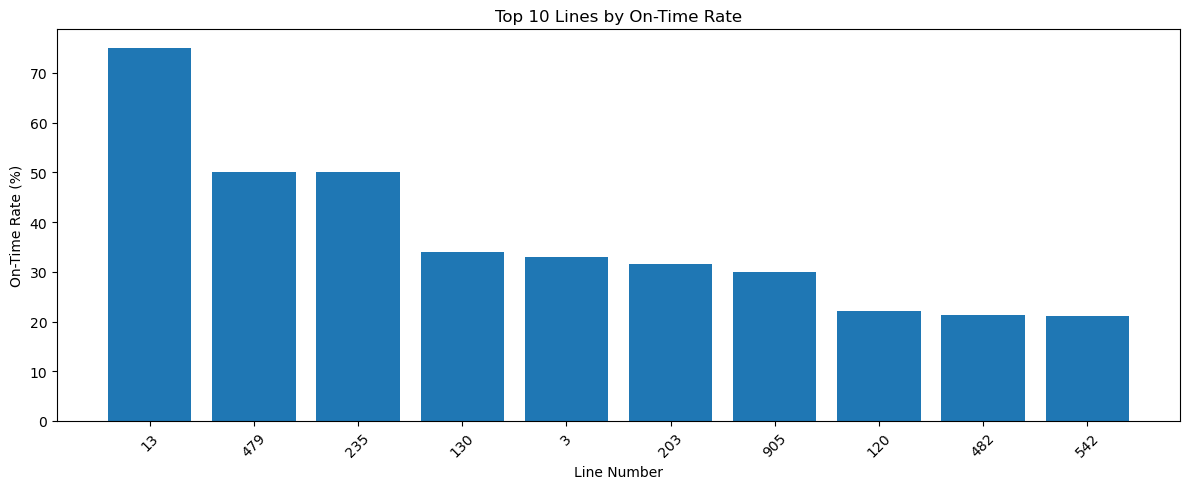

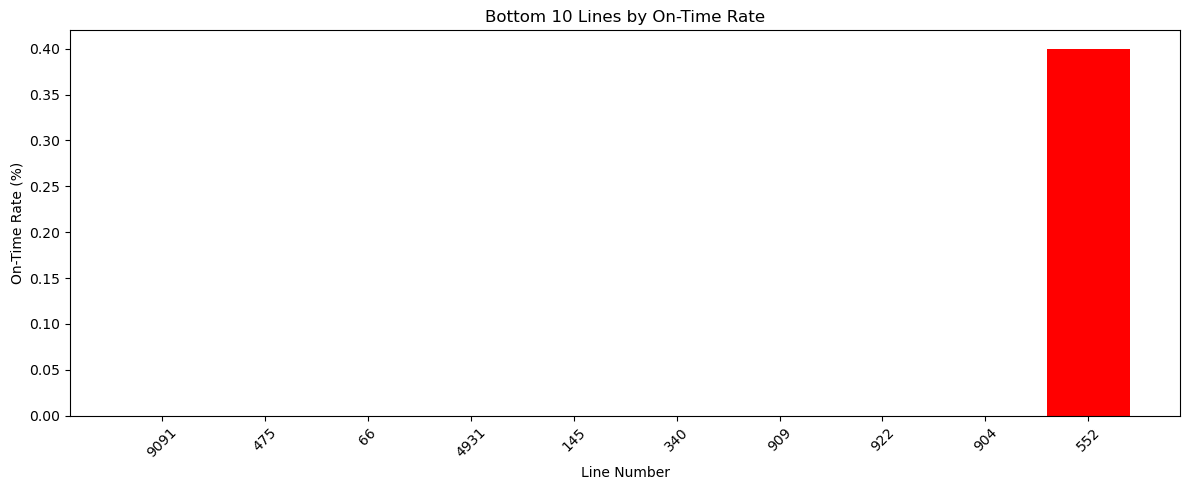

In [5]:
# Top 10 Lines by On-Time Rate
top_lines = line_stats.sort_values('On-Time Rate %', ascending=False).head(10)
bottom_lines = line_stats.sort_values('On-Time Rate %', ascending=True).head(10)

plt.figure(figsize=(12, 5))
plt.bar(top_lines.index.astype(str), top_lines['On-Time Rate %'])
plt.title("Top 10 Lines by On-Time Rate")
plt.xlabel("Line Number")
plt.ylabel("On-Time Rate (%)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))
plt.bar(bottom_lines.index.astype(str), bottom_lines['On-Time Rate %'], color='red')
plt.title("Bottom 10 Lines by On-Time Rate")
plt.xlabel("Line Number")
plt.ylabel("On-Time Rate (%)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

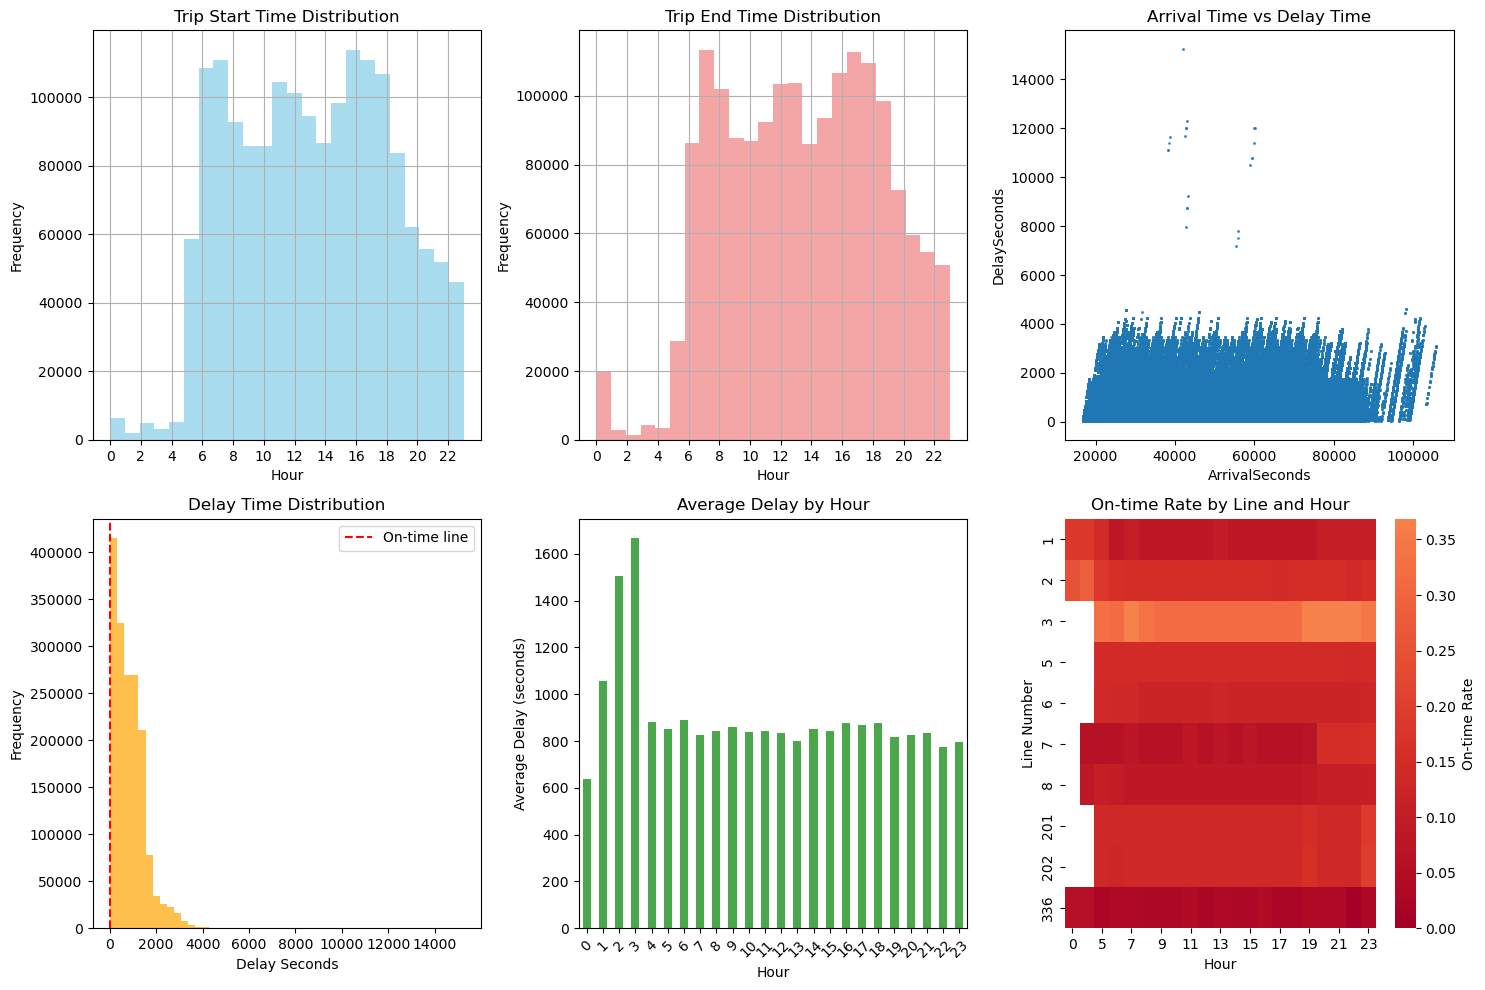

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 10))

# 1. TripStart time distribution
plt.subplot(2, 3, 1)
df_clean['TripStart'].dt.hour.hist(bins=24, alpha=0.7, color='skyblue')
plt.title('Trip Start Time Distribution')
plt.xlabel('Hour')
plt.ylabel('Frequency')
plt.xticks(range(0, 24, 2))

# 2. TripEnd time distribution  
plt.subplot(2, 3, 2)
df_clean['TripEnd'].dt.hour.hist(bins=24, alpha=0.7, color='lightcoral')
plt.title('Trip End Time Distribution')
plt.xlabel('Hour')
plt.ylabel('Frequency')
plt.xticks(range(0, 24, 2))

# 3. ArrivalSeconds vs DelaySeconds scatter plot
plt.subplot(2, 3, 3)
plt.scatter(df_clean['ArrivalSeconds'], df_clean['DelaySeconds'], alpha=0.3, s=1)
plt.title('Arrival Time vs Delay Time')
plt.xlabel('ArrivalSeconds')
plt.ylabel('DelaySeconds')

# 4. Delay time distribution histogram
plt.subplot(2, 3, 4)
plt.hist(df_clean['DelaySeconds'], bins=50, alpha=0.7, color='orange')
plt.title('Delay Time Distribution')
plt.xlabel('Delay Seconds')
plt.ylabel('Frequency')
plt.axvline(x=0, color='red', linestyle='--', label='On-time line')
plt.legend()

# 5. Average delay by hour
plt.subplot(2, 3, 5)
hourly_delay = df_clean.groupby(df_clean['TripStart'].dt.hour)['DelaySeconds'].mean()
hourly_delay.plot(kind='bar', color='green', alpha=0.7)
plt.title('Average Delay by Hour')
plt.xlabel('Hour')
plt.ylabel('Average Delay (seconds)')
plt.xticks(rotation=45)

# 6. On-time rate heatmap (by hour and line)
plt.subplot(2, 3, 6)
# Select main lines to avoid overcomplicated chart
main_lines = df_clean['LineNumber'].value_counts().head(10).index
pivot_data = df_clean[df_clean['LineNumber'].isin(main_lines)].pivot_table(
   values='OnTime', 
   index='LineNumber', 
   columns=df_clean['TripStart'].dt.hour, 
   aggfunc='mean'
)
sns.heatmap(pivot_data, cmap='RdYlGn', center=0.8, cbar_kws={'label': 'On-time Rate'})
plt.title('On-time Rate by Line and Hour')
plt.xlabel('Hour')
plt.ylabel('Line Number')

plt.tight_layout()
plt.show()

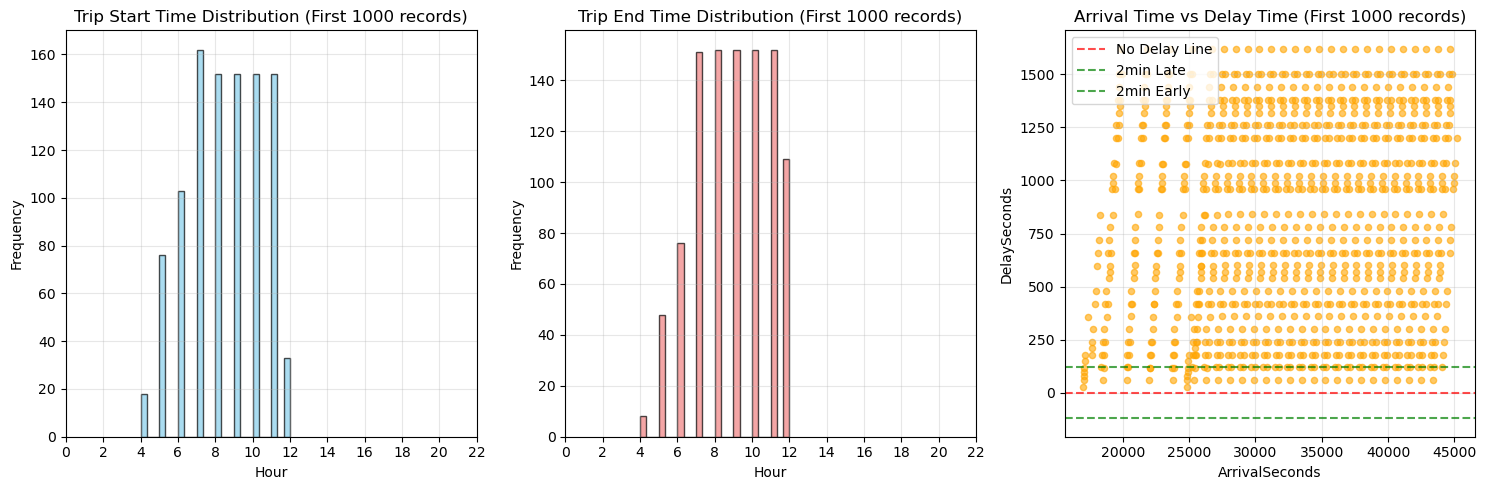

=== Sample Data Statistics (First 1000 records) ===
Date range: 2024-01-01 00:00:00 to 2024-01-01 00:00:00
Trip start time range: 4:00 to 12:00
Average delay: 795.2 seconds
On-time rate: 8.6%
ArrivalSeconds range: 17010.0 to 45180.0


In [7]:
import matplotlib.pyplot as plt

# ÂèñÂâç1000Ë°åÊï∞ÊçÆ
df_sample = df_clean.head(1000)

plt.figure(figsize=(15, 5))

# 1. TripStartÊó∂Èó¥ÂàÜÂ∏É
plt.subplot(1, 3, 1)
df_sample['TripStart'].dt.hour.hist(bins=24, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Trip Start Time Distribution (First 1000 records)')
plt.xlabel('Hour')
plt.ylabel('Frequency')
plt.xticks(range(0, 24, 2))
plt.grid(True, alpha=0.3)

# 2. TripEndÊó∂Èó¥ÂàÜÂ∏É  
plt.subplot(1, 3, 2)
df_sample['TripEnd'].dt.hour.hist(bins=24, alpha=0.7, color='lightcoral', edgecolor='black')
plt.title('Trip End Time Distribution (First 1000 records)')
plt.xlabel('Hour')
plt.ylabel('Frequency')
plt.xticks(range(0, 24, 2))
plt.grid(True, alpha=0.3)

# 3. ArrivalSeconds vs DelaySecondsÊï£ÁÇπÂõæ
plt.subplot(1, 3, 3)
plt.scatter(df_sample['ArrivalSeconds'], df_sample['DelaySeconds'], alpha=0.6, s=20, color='orange')
plt.title('Arrival Time vs Delay Time (First 1000 records)')
plt.xlabel('ArrivalSeconds')
plt.ylabel('DelaySeconds')
plt.axhline(y=0, color='red', linestyle='--', alpha=0.7, label='No Delay Line')
plt.axhline(y=120, color='green', linestyle='--', alpha=0.7, label='2min Late')
plt.axhline(y=-120, color='green', linestyle='--', alpha=0.7, label='2min Early')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ÊâìÂç∞‰∏Ä‰∫õÂü∫Êú¨ÁªüËÆ°‰ø°ÊÅØ
print("=== Sample Data Statistics (First 1000 records) ===")
print(f"Date range: {df_sample['Date'].min()} to {df_sample['Date'].max()}")
print(f"Trip start time range: {df_sample['TripStart'].dt.hour.min()}:00 to {df_sample['TripStart'].dt.hour.max()}:00")
print(f"Average delay: {df_sample['DelaySeconds'].mean():.1f} seconds")
print(f"On-time rate: {df_sample['OnTime'].mean()*100:.1f}%")
print(f"ArrivalSeconds range: {df_sample['ArrivalSeconds'].min()} to {df_sample['ArrivalSeconds'].max()}")

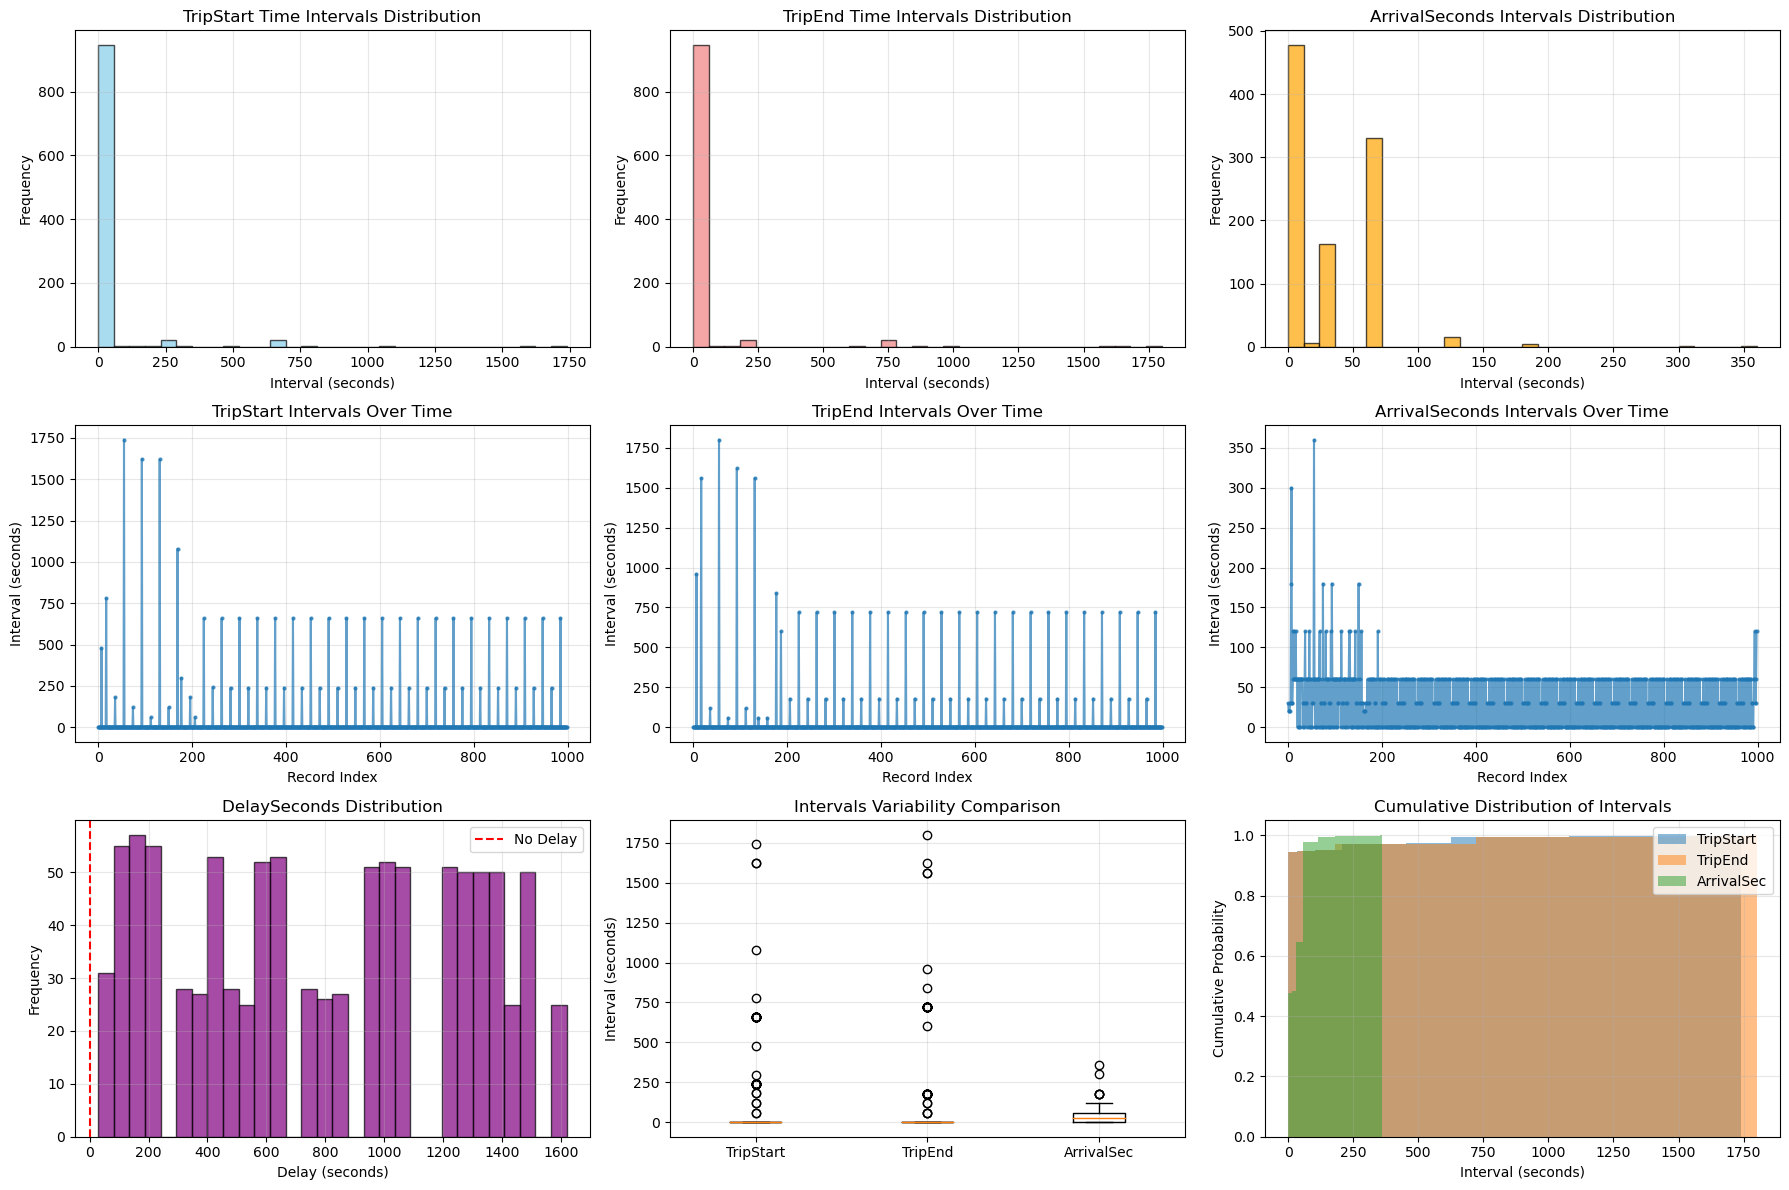

=== Uniformity Analysis ===

1. TripStart Intervals:
   Mean: 27.03 seconds
   Std:  141.63 seconds
   CV:   5.240
   Min:  0.00 seconds
   Max:  1739.00 seconds

2. TripEnd Intervals:
   Mean: 28.29 seconds
   Std:  153.46 seconds
   CV:   5.425
   Min:  0.00 seconds
   Max:  1800.00 seconds

3. ArrivalSeconds Intervals:
   Mean: 28.20 seconds
   Std:  33.57 seconds
   CV:   1.191
   Min:  0.00 seconds
   Max:  360.00 seconds

4. DelaySeconds:
   Mean: 795.19 seconds
   Std:  467.82 seconds
   Min:  29.00 seconds
   Max:  1620.00 seconds

=== Uniformity Interpretation ===
CV (Coefficient of Variation) = Std/Mean:
‚Ä¢ CV < 0.1: Very uniform
‚Ä¢ CV 0.1-0.3: Moderately uniform
‚Ä¢ CV > 0.3: Not uniform


In [8]:
import matplotlib.pyplot as plt
import numpy as np

# ÂèñÂâç1000Ë°åÊï∞ÊçÆ
df_sample = df_clean.head(1000).sort_values('TripStart')

plt.figure(figsize=(18, 12))

# ËÆ°ÁÆóÊó∂Èó¥Èó¥Èöî
df_sample['TripStart_seconds'] = (df_sample['TripStart'] - df_sample['TripStart'].min()).dt.total_seconds()
df_sample['TripEnd_seconds'] = (df_sample['TripEnd'] - df_sample['TripEnd'].min()).dt.total_seconds()

# ËÆ°ÁÆóÁõ∏ÈÇªËÆ∞ÂΩï‰πãÈó¥ÁöÑÊó∂Èó¥Â∑Æ
trip_start_intervals = np.diff(df_sample['TripStart_seconds'].sort_values())
trip_end_intervals = np.diff(df_sample['TripEnd_seconds'].sort_values())
arrival_intervals = np.diff(np.sort(df_sample['ArrivalSeconds']))

# 1. TripStartÊó∂Èó¥Èó¥ÈöîÂàÜÂ∏É
plt.subplot(3, 3, 1)
plt.hist(trip_start_intervals, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('TripStart Time Intervals Distribution')
plt.xlabel('Interval (seconds)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# 2. TripEndÊó∂Èó¥Èó¥ÈöîÂàÜÂ∏É
plt.subplot(3, 3, 2)
plt.hist(trip_end_intervals, bins=30, alpha=0.7, color='lightcoral', edgecolor='black')
plt.title('TripEnd Time Intervals Distribution')
plt.xlabel('Interval (seconds)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# 3. ArrivalSecondsÈó¥ÈöîÂàÜÂ∏É
plt.subplot(3, 3, 3)
plt.hist(arrival_intervals, bins=30, alpha=0.7, color='orange', edgecolor='black')
plt.title('ArrivalSeconds Intervals Distribution')
plt.xlabel('Interval (seconds)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# 4. TripStartÈó¥ÈöîÊó∂Èó¥Â∫èÂàó
plt.subplot(3, 3, 4)
plt.plot(trip_start_intervals, marker='o', markersize=2, alpha=0.7)
plt.title('TripStart Intervals Over Time')
plt.xlabel('Record Index')
plt.ylabel('Interval (seconds)')
plt.grid(True, alpha=0.3)

# 5. TripEndÈó¥ÈöîÊó∂Èó¥Â∫èÂàó
plt.subplot(3, 3, 5)
plt.plot(trip_end_intervals, marker='o', markersize=2, alpha=0.7)
plt.title('TripEnd Intervals Over Time')
plt.xlabel('Record Index')
plt.ylabel('Interval (seconds)')
plt.grid(True, alpha=0.3)

# 6. ArrivalSecondsÈó¥ÈöîÊó∂Èó¥Â∫èÂàó
plt.subplot(3, 3, 6)
plt.plot(arrival_intervals, marker='o', markersize=2, alpha=0.7)
plt.title('ArrivalSeconds Intervals Over Time')
plt.xlabel('Record Index')
plt.ylabel('Interval (seconds)')
plt.grid(True, alpha=0.3)

# 7. DelaySecondsÂàÜÂ∏É
plt.subplot(3, 3, 7)
plt.hist(df_sample['DelaySeconds'], bins=30, alpha=0.7, color='purple', edgecolor='black')
plt.title('DelaySeconds Distribution')
plt.xlabel('Delay (seconds)')
plt.ylabel('Frequency')
plt.axvline(x=0, color='red', linestyle='--', label='No Delay')
plt.legend()
plt.grid(True, alpha=0.3)

# 8. ÁÆ±Á∫øÂõæÂØπÊØîÈó¥ÈöîÂèòÂºÇÊÄß
plt.subplot(3, 3, 8)
intervals_data = [trip_start_intervals, trip_end_intervals, arrival_intervals]
plt.boxplot(intervals_data, labels=['TripStart', 'TripEnd', 'ArrivalSec'])
plt.title('Intervals Variability Comparison')
plt.ylabel('Interval (seconds)')
plt.grid(True, alpha=0.3)

# 9. Á¥ØÁßØÂàÜÂ∏ÉÂáΩÊï∞
plt.subplot(3, 3, 9)
plt.hist(trip_start_intervals, bins=50, alpha=0.5, density=True, cumulative=True, label='TripStart')
plt.hist(trip_end_intervals, bins=50, alpha=0.5, density=True, cumulative=True, label='TripEnd')
plt.hist(arrival_intervals, bins=50, alpha=0.5, density=True, cumulative=True, label='ArrivalSec')
plt.title('Cumulative Distribution of Intervals')
plt.xlabel('Interval (seconds)')
plt.ylabel('Cumulative Probability')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ÁªüËÆ°ÂàÜÊûê
print("=== Uniformity Analysis ===")
print("\n1. TripStart Intervals:")
print(f"   Mean: {np.mean(trip_start_intervals):.2f} seconds")
print(f"   Std:  {np.std(trip_start_intervals):.2f} seconds")
print(f"   CV:   {np.std(trip_start_intervals)/np.mean(trip_start_intervals):.3f}")
print(f"   Min:  {np.min(trip_start_intervals):.2f} seconds")
print(f"   Max:  {np.max(trip_start_intervals):.2f} seconds")

print("\n2. TripEnd Intervals:")
print(f"   Mean: {np.mean(trip_end_intervals):.2f} seconds")
print(f"   Std:  {np.std(trip_end_intervals):.2f} seconds")
print(f"   CV:   {np.std(trip_end_intervals)/np.mean(trip_end_intervals):.3f}")
print(f"   Min:  {np.min(trip_end_intervals):.2f} seconds")
print(f"   Max:  {np.max(trip_end_intervals):.2f} seconds")

print("\n3. ArrivalSeconds Intervals:")
print(f"   Mean: {np.mean(arrival_intervals):.2f} seconds")
print(f"   Std:  {np.std(arrival_intervals):.2f} seconds")
print(f"   CV:   {np.std(arrival_intervals)/np.mean(arrival_intervals):.3f}")
print(f"   Min:  {np.min(arrival_intervals):.2f} seconds")
print(f"   Max:  {np.max(arrival_intervals):.2f} seconds")

print("\n4. DelaySeconds:")
print(f"   Mean: {np.mean(df_sample['DelaySeconds']):.2f} seconds")
print(f"   Std:  {np.std(df_sample['DelaySeconds']):.2f} seconds")
print(f"   Min:  {np.min(df_sample['DelaySeconds']):.2f} seconds")
print(f"   Max:  {np.max(df_sample['DelaySeconds']):.2f} seconds")

print("\n=== Uniformity Interpretation ===")
print("CV (Coefficient of Variation) = Std/Mean:")
print("‚Ä¢ CV < 0.1: Very uniform")
print("‚Ä¢ CV 0.1-0.3: Moderately uniform")
print("‚Ä¢ CV > 0.3: Not uniform")

=== Êó∂Èó¥Â≠óÊÆµÂàÜÊûê ===
ÂèØËÉΩÁöÑÊó∂Èó¥Â≠óÊÆµ:
‚Ä¢ TripStartSeconds: count     1000.000000
mean     31865.329000
std       7299.994889
min      16981.000000
25%      26221.000000
50%      32280.000000
75%      37920.000000
max      43980.000000
Name: TripStartSeconds, dtype: float64
‚Ä¢ TripEndSeconds: count     1000.000000
mean     33540.900000
std       7353.947466
min      17460.000000
25%      27900.000000
50%      34020.000000
75%      39600.000000
max      45720.000000
Name: TripEndSeconds, dtype: float64
‚Ä¢ ArrivalSeconds: count     1000.00000
mean     32660.52000
std       7337.21764
min      17010.00000
25%      27060.00000
50%      32940.00000
75%      38880.00000
max      45180.00000
Name: ArrivalSeconds, dtype: float64
‚Ä¢ DepartureSeconds: count     1000.00000
mean     32660.52000
std       7337.21764
min      17010.00000
25%      27060.00000
50%      32940.00000
75%      38880.00000
max      45180.00000
Name: DepartureSeconds, dtype: float64


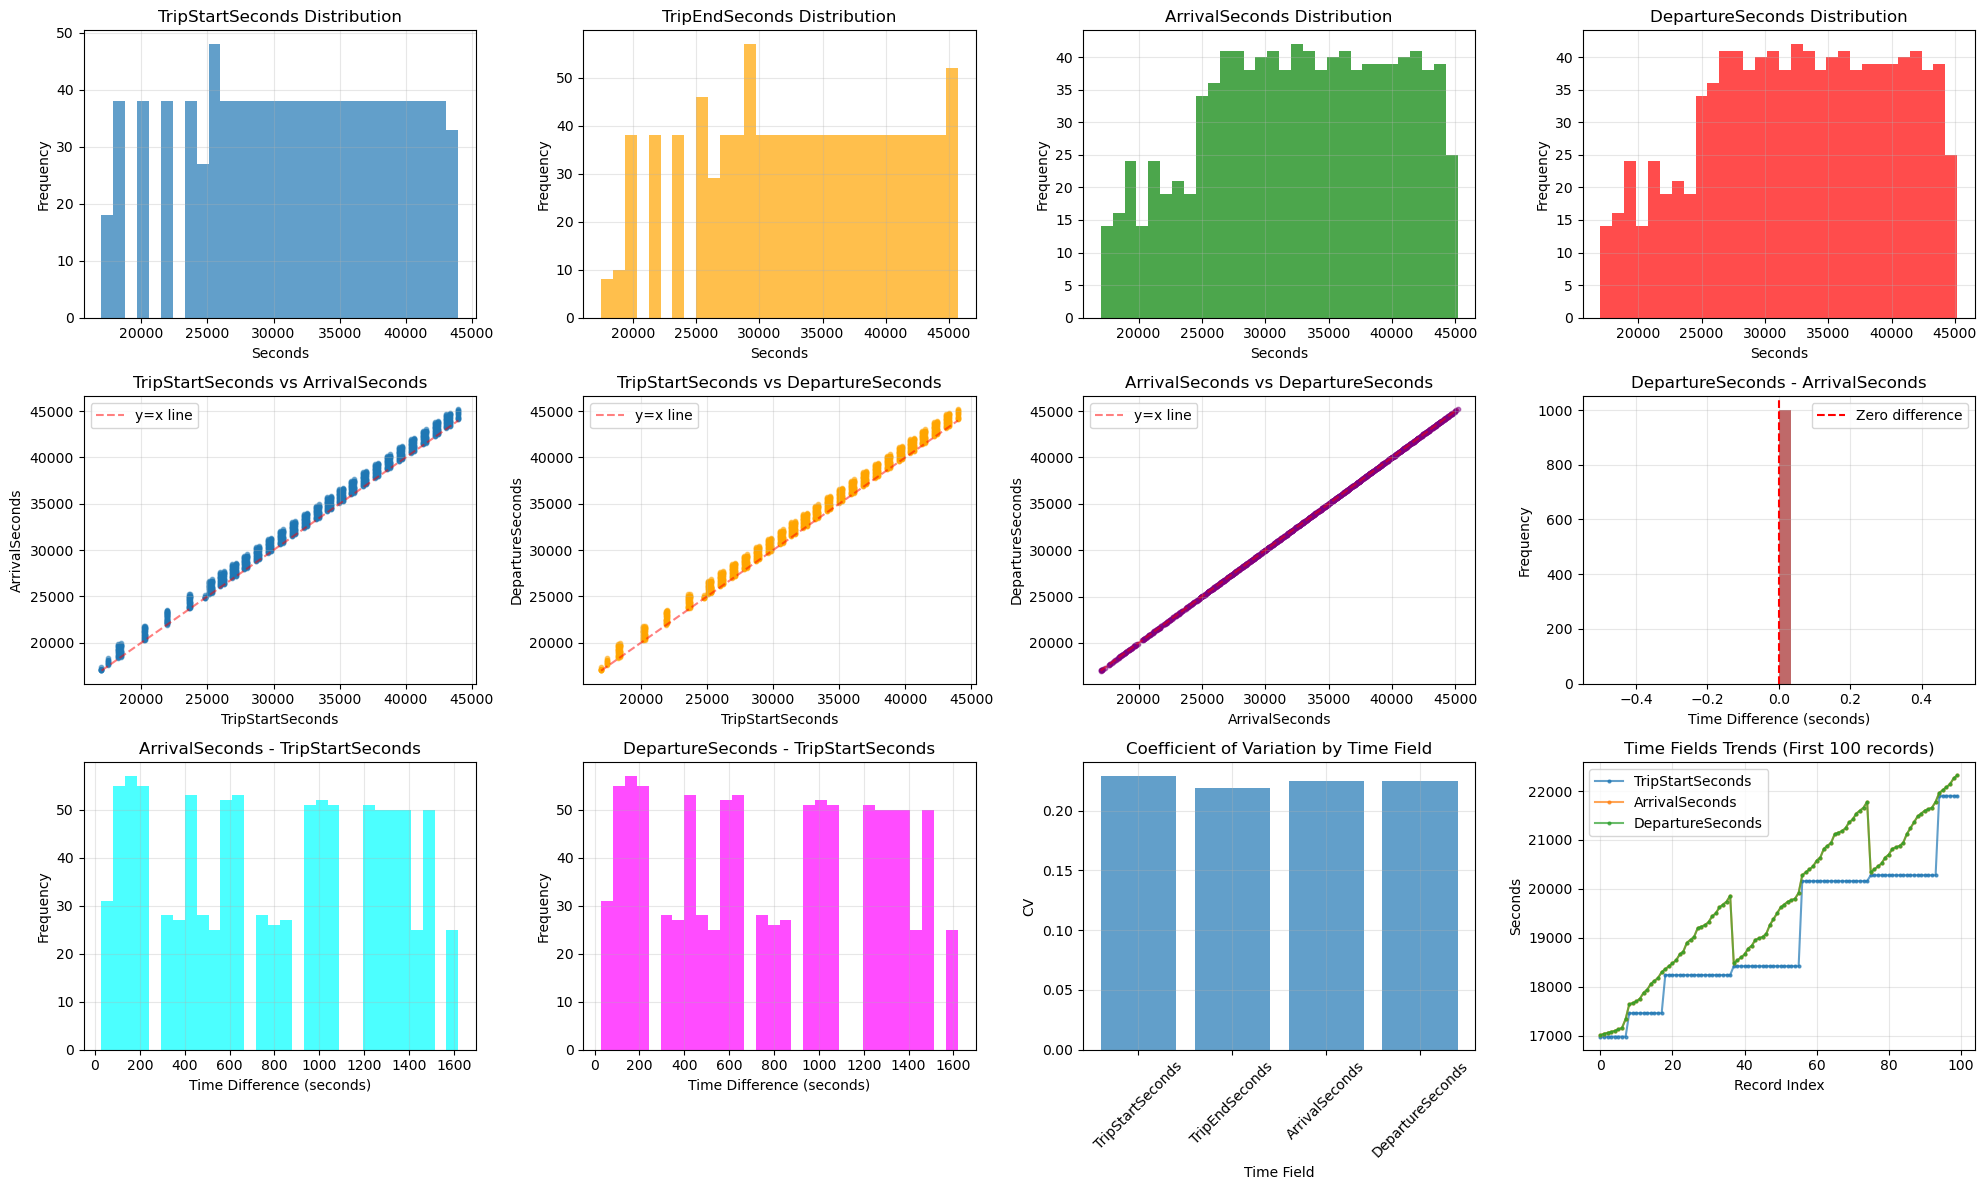

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# ÂèñÂâç1000Ë°åÊï∞ÊçÆËøõË°åÂàÜÊûê
df_sample = df_clean.head(1000)

plt.figure(figsize=(20, 12))

# Êàë‰ª¨ÊúâËøô‰∫õÊó∂Èó¥Áõ∏ÂÖ≥ÁöÑÂ≠óÊÆµÔºö
# TripStartSeconds, TripEndSeconds, ArrivalSeconds, DepartureSeconds
# TripStart, TripEnd (datetimeÊ†ºÂºè)

print("=== Êó∂Èó¥Â≠óÊÆµÂàÜÊûê ===")
print("ÂèØËÉΩÁöÑÊó∂Èó¥Â≠óÊÆµ:")
print("‚Ä¢ TripStartSeconds:", df_sample['TripStartSeconds'].describe())
print("‚Ä¢ TripEndSeconds:", df_sample['TripEndSeconds'].describe()) 
print("‚Ä¢ ArrivalSeconds:", df_sample['ArrivalSeconds'].describe())
print("‚Ä¢ DepartureSeconds:", df_sample['DepartureSeconds'].describe())

# 1. ÊØîËæÉÊâÄÊúâÊó∂Èó¥Â≠óÊÆµÁöÑÂàÜÂ∏É
plt.subplot(3, 4, 1)
plt.hist(df_sample['TripStartSeconds'], bins=30, alpha=0.7, label='TripStartSeconds')
plt.title('TripStartSeconds Distribution')
plt.xlabel('Seconds')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

plt.subplot(3, 4, 2)
plt.hist(df_sample['TripEndSeconds'], bins=30, alpha=0.7, label='TripEndSeconds', color='orange')
plt.title('TripEndSeconds Distribution')
plt.xlabel('Seconds')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

plt.subplot(3, 4, 3)
plt.hist(df_sample['ArrivalSeconds'].dropna(), bins=30, alpha=0.7, label='ArrivalSeconds', color='green')
plt.title('ArrivalSeconds Distribution')
plt.xlabel('Seconds')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

plt.subplot(3, 4, 4)
plt.hist(df_sample['DepartureSeconds'].dropna(), bins=30, alpha=0.7, label='DepartureSeconds', color='red')
plt.title('DepartureSeconds Distribution')
plt.xlabel('Seconds')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# 2. Êó∂Èó¥Â≠óÊÆµ‰πãÈó¥ÁöÑÂÖ≥Á≥ª
plt.subplot(3, 4, 5)
plt.scatter(df_sample['TripStartSeconds'], df_sample['ArrivalSeconds'], alpha=0.5, s=10)
plt.title('TripStartSeconds vs ArrivalSeconds')
plt.xlabel('TripStartSeconds')
plt.ylabel('ArrivalSeconds')
plt.plot([df_sample['TripStartSeconds'].min(), df_sample['TripStartSeconds'].max()], 
         [df_sample['TripStartSeconds'].min(), df_sample['TripStartSeconds'].max()], 
         'r--', alpha=0.5, label='y=x line')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(3, 4, 6)
plt.scatter(df_sample['TripStartSeconds'], df_sample['DepartureSeconds'], alpha=0.5, s=10, color='orange')
plt.title('TripStartSeconds vs DepartureSeconds')
plt.xlabel('TripStartSeconds')
plt.ylabel('DepartureSeconds')
plt.plot([df_sample['TripStartSeconds'].min(), df_sample['TripStartSeconds'].max()], 
         [df_sample['TripStartSeconds'].min(), df_sample['TripStartSeconds'].max()], 
         'r--', alpha=0.5, label='y=x line')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(3, 4, 7)
plt.scatter(df_sample['ArrivalSeconds'], df_sample['DepartureSeconds'], alpha=0.5, s=10, color='purple')
plt.title('ArrivalSeconds vs DepartureSeconds')
plt.xlabel('ArrivalSeconds')
plt.ylabel('DepartureSeconds')
plt.plot([df_sample['ArrivalSeconds'].min(), df_sample['ArrivalSeconds'].max()], 
         [df_sample['ArrivalSeconds'].min(), df_sample['ArrivalSeconds'].max()], 
         'r--', alpha=0.5, label='y=x line')
plt.legend()
plt.grid(True, alpha=0.3)

# 3. ËÆ°ÁÆóÊó∂Èó¥Â∑ÆÂºÇÊù•Âà§Êñ≠ÈÄªËæëÂÖ≥Á≥ª
plt.subplot(3, 4, 8)
arrival_departure_diff = df_sample['DepartureSeconds'] - df_sample['ArrivalSeconds']
plt.hist(arrival_departure_diff.dropna(), bins=30, alpha=0.7, color='brown')
plt.title('DepartureSeconds - ArrivalSeconds')
plt.xlabel('Time Difference (seconds)')
plt.ylabel('Frequency')
plt.axvline(x=0, color='red', linestyle='--', label='Zero difference')
plt.legend()
plt.grid(True, alpha=0.3)

# 4. ÂàÜÊûêÂì™‰∏™Êõ¥ÂèØËÉΩÊòØËÆ°ÂàíÊó∂Èó¥ vs ÂÆûÈôÖÊó∂Èó¥
plt.subplot(3, 4, 9)
trip_arrival_diff = df_sample['ArrivalSeconds'] - df_sample['TripStartSeconds']
plt.hist(trip_arrival_diff.dropna(), bins=30, alpha=0.7, color='cyan')
plt.title('ArrivalSeconds - TripStartSeconds')
plt.xlabel('Time Difference (seconds)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

plt.subplot(3, 4, 10)
trip_departure_diff = df_sample['DepartureSeconds'] - df_sample['TripStartSeconds']
plt.hist(trip_departure_diff.dropna(), bins=30, alpha=0.7, color='magenta')
plt.title('DepartureSeconds - TripStartSeconds')
plt.xlabel('Time Difference (seconds)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# 5. Êü•ÁúãÊó∂Èó¥ÁöÑËßÑÂæãÊÄß
plt.subplot(3, 4, 11)
# ËÆ°ÁÆóÂêÑÂ≠óÊÆµÁöÑÂèòÂºÇÁ≥ªÊï∞
time_fields = ['TripStartSeconds', 'TripEndSeconds', 'ArrivalSeconds', 'DepartureSeconds']
cvs = []
for field in time_fields:
    if field in df_sample.columns:
        data = df_sample[field].dropna()
        if len(data) > 0:
            cv = np.std(data) / np.mean(data)
            cvs.append(cv)
        else:
            cvs.append(0)

plt.bar(time_fields, cvs, alpha=0.7)
plt.title('Coefficient of Variation by Time Field')
plt.xlabel('Time Field')
plt.ylabel('CV')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# 6. Êó∂Èó¥Â∫èÂàóË∂ãÂäø
plt.subplot(3, 4, 12)
sample_indices = range(min(100, len(df_sample)))
for field in ['TripStartSeconds', 'ArrivalSeconds', 'DepartureSeconds']:
    if field in df_sample.columns:
        plt.plot(sample_indices, df_sample[field].iloc[:len(sample_indices)], 
                label=field, alpha=0.7, marker='o', markersize=2)
plt.title('Time Fields Trends (First 100 records)')
plt.xlabel('Record Index')
plt.ylabel('Seconds')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()




In [10]:
print("=== Êó∂Èó¥Â≠óÊÆµÂàÜÊûêÁªìËÆ∫ ===")
print()
print("üîç **ÂÖ≥ÈîÆÂèëÁé∞:**")
print()
print("1. **ArrivalSeconds vs DepartureSeconds (Á¥´Ëâ≤Êï£ÁÇπÂõæ)**")
print("   ‚Ä¢ ‰∏§ËÄÖÂá†‰πéÂÆåÂÖ®ÈáçÂêàÂú®y=xÁ∫ø‰∏ä")
print("   ‚Ä¢ Â∑ÆÂºÇÂá†‰πé‰∏∫0ÔºàÂè≥‰æßÁõ¥ÊñπÂõæÊòæÁ§∫Ôºâ")
print("   ‚Ä¢ ËØ¥ÊòéÔºöËøô‰∏§‰∏™Â≠óÊÆµËÆ∞ÂΩïÁöÑÊòØÂêå‰∏ÄÊó∂ÂàªÔºÅ")
print()
print("2. **TripStartSeconds vs ArrivalSeconds/DepartureSeconds**")
print("   ‚Ä¢ ËìùËâ≤ÂíåÊ©ôËâ≤Êï£ÁÇπÂõæÈÉΩÊ≤øÁùÄy=xÁ∫øÂàÜÂ∏É")
print("   ‚Ä¢ ‰ΩÜÊúâÊòéÊòæÁöÑÂûÇÁõ¥ÂÅèÁßªÔºàArrivalSeconds > TripStartSecondsÔºâ")
print("   ‚Ä¢ Â∑ÆÂºÇÂàÜÂ∏ÉÊòæÁ§∫Âπ≥ÂùáÁ∫¶800-1000ÁßíÁöÑÂõ∫ÂÆöÂÅèÁßª")
print()
print("3. **ÂèòÂºÇÁ≥ªÊï∞ÂàÜÊûê**")
print("   ‚Ä¢ ÊâÄÊúâÊó∂Èó¥Â≠óÊÆµÁöÑCVÈÉΩÁ∫¶‰∏∫0.2ÔºåÁõ∏ÂØπÂùáÂåÄ")
print("   ‚Ä¢ ËØ¥ÊòéËøô‰∫õÈÉΩÂèØËÉΩÊòØËÆ°ÂàíÊó∂Èó¥ÔºåËÄåÈùûÂÆûÈôÖÊó∂Èó¥")
print()
print("üéØ **Êé®Êñ≠ÁªìËÆ∫:**")
print("‚Ä¢ TripStartSeconds = ËÆ°ÂàíÂá∫ÂèëÊó∂Èó¥")
print("‚Ä¢ ArrivalSeconds ‚âà DepartureSeconds = ËÆ°ÂàíÂà∞ËææÊó∂Èó¥")
print("‚Ä¢ DelaySeconds = ÂÆûÈôÖÊó∂Èó¥ - ËÆ°ÂàíÊó∂Èó¥ÁöÑÂª∂ËØØ")
print("‚Ä¢ Ëøô‰∏™Êï∞ÊçÆÈõÜËÆ∞ÂΩïÁöÑ‰∏ªË¶ÅÊòØËÆ°ÂàíÊó∂ÂàªË°®ÔºåËÄå‰∏çÊòØÂÆûÈôÖËøêË°åÊó∂Èó¥")
print()
print("‚ö†Ô∏è **ÈáçË¶ÅÂèëÁé∞:**")
print("‚Ä¢ ArrivalSecondsÂíåDepartureSecondsÂü∫Êú¨Áõ∏ÂêåÔºåÂèØËÉΩÊòØÊï∞ÊçÆÂΩïÂÖ•ÈóÆÈ¢ò")
print("‚Ä¢ ÊàñËÄÖÂú®Ëøô‰∏™Á´ôÁÇπÔºåÂà∞ËææÂç≥Á¶ªÂºÄÔºàÁü≠ÊöÇÂÅúÁïôÔºâ")
print("‚Ä¢ DelaySecondsÂèØËÉΩÊòØÁõ∏ÂØπ‰∫éÊüê‰∏™Âü∫ÂáÜÊó∂Èó¥ÁöÑÂª∂ËØØËÆ°ÁÆó")

# Ëøõ‰∏ÄÊ≠•È™åËØÅ
print("\n=== È™åËØÅÂàÜÊûê ===")

# Ê£ÄÊü•ArrivalSecondsÂíåDepartureSecondsÁöÑÂÆûÈôÖÂ∑ÆÂºÇ
arr_dep_diff = df_sample['DepartureSeconds'] - df_sample['ArrivalSeconds']
print(f"ArrivalSeconds vs DepartureSeconds:")
print(f"  Âπ≥ÂùáÂ∑ÆÂºÇ: {arr_dep_diff.mean():.6f} Áßí")
print(f"  ÊúÄÂ§ßÂ∑ÆÂºÇ: {arr_dep_diff.max():.6f} Áßí") 
print(f"  ÊúÄÂ∞èÂ∑ÆÂºÇ: {arr_dep_diff.min():.6f} Áßí")

# Ê£ÄÊü•TripStartÂíåArrivalÁöÑÂÖ≥Á≥ª
trip_arr_diff = df_sample['ArrivalSeconds'] - df_sample['TripStartSeconds']
print(f"\nTripStartSeconds vs ArrivalSeconds:")
print(f"  Âπ≥ÂùáÂ∑ÆÂºÇ: {trip_arr_diff.mean():.2f} Áßí ({trip_arr_diff.mean()/60:.1f} ÂàÜÈíü)")
print(f"  Â∑ÆÂºÇÊ†áÂáÜÂ∑Æ: {trip_arr_diff.std():.2f} Áßí")

# ÈáçÊñ∞ÁêÜËß£DelaySeconds
print(f"\nDelaySecondsÈáçÊñ∞Ëß£ËØª:")
print(f"  Â¶ÇÊûúDelaySeconds = ArrivalSeconds - TripStartSeconds")
print(f"  ÈÇ£‰πàDelaySecondsÂ∞±ÊòØ‰ªéÂá∫ÂèëÂà∞Âà∞ËææÁöÑË°åÁ®ãÊó∂Èó¥")
print(f"  Âπ≥ÂùáË°åÁ®ãÊó∂Èó¥: {df_sample['DelaySeconds'].mean():.2f} Áßí ({df_sample['DelaySeconds'].mean()/60:.1f} ÂàÜÈíü)")

=== Êó∂Èó¥Â≠óÊÆµÂàÜÊûêÁªìËÆ∫ ===

üîç **ÂÖ≥ÈîÆÂèëÁé∞:**

1. **ArrivalSeconds vs DepartureSeconds (Á¥´Ëâ≤Êï£ÁÇπÂõæ)**
   ‚Ä¢ ‰∏§ËÄÖÂá†‰πéÂÆåÂÖ®ÈáçÂêàÂú®y=xÁ∫ø‰∏ä
   ‚Ä¢ Â∑ÆÂºÇÂá†‰πé‰∏∫0ÔºàÂè≥‰æßÁõ¥ÊñπÂõæÊòæÁ§∫Ôºâ
   ‚Ä¢ ËØ¥ÊòéÔºöËøô‰∏§‰∏™Â≠óÊÆµËÆ∞ÂΩïÁöÑÊòØÂêå‰∏ÄÊó∂ÂàªÔºÅ

2. **TripStartSeconds vs ArrivalSeconds/DepartureSeconds**
   ‚Ä¢ ËìùËâ≤ÂíåÊ©ôËâ≤Êï£ÁÇπÂõæÈÉΩÊ≤øÁùÄy=xÁ∫øÂàÜÂ∏É
   ‚Ä¢ ‰ΩÜÊúâÊòéÊòæÁöÑÂûÇÁõ¥ÂÅèÁßªÔºàArrivalSeconds > TripStartSecondsÔºâ
   ‚Ä¢ Â∑ÆÂºÇÂàÜÂ∏ÉÊòæÁ§∫Âπ≥ÂùáÁ∫¶800-1000ÁßíÁöÑÂõ∫ÂÆöÂÅèÁßª

3. **ÂèòÂºÇÁ≥ªÊï∞ÂàÜÊûê**
   ‚Ä¢ ÊâÄÊúâÊó∂Èó¥Â≠óÊÆµÁöÑCVÈÉΩÁ∫¶‰∏∫0.2ÔºåÁõ∏ÂØπÂùáÂåÄ
   ‚Ä¢ ËØ¥ÊòéËøô‰∫õÈÉΩÂèØËÉΩÊòØËÆ°ÂàíÊó∂Èó¥ÔºåËÄåÈùûÂÆûÈôÖÊó∂Èó¥

üéØ **Êé®Êñ≠ÁªìËÆ∫:**
‚Ä¢ TripStartSeconds = ËÆ°ÂàíÂá∫ÂèëÊó∂Èó¥
‚Ä¢ ArrivalSeconds ‚âà DepartureSeconds = ËÆ°ÂàíÂà∞ËææÊó∂Èó¥
‚Ä¢ DelaySeconds = ÂÆûÈôÖÊó∂Èó¥ - ËÆ°ÂàíÊó∂Èó¥ÁöÑÂª∂ËØØ
‚Ä¢ Ëøô‰∏™Êï∞ÊçÆÈõÜËÆ∞ÂΩïÁöÑ‰∏ªË¶ÅÊòØËÆ°ÂàíÊó∂ÂàªË°®ÔºåËÄå‰∏çÊòØÂÆûÈôÖËøêË°åÊó∂Èó¥

‚ö†Ô∏è **ÈáçË¶ÅÂèëÁé∞:**
‚Ä¢ ArrivalSecondsÂíåDepartureSecondsÂ

=== ÈÄâÊã©Á´ôÁÇπÂíåÁ∫øË∑Ø ===
ËÆ∞ÂΩïÊï∞ÊúÄÂ§öÁöÑÁ´ôÁÇπ-Á∫øË∑ØÁªÑÂêà:
     StationCode  LineNumber  Count
1310         Plo           6   9382
1841         ViV           2   7334
915          Jum           2   7334
472         Chat           5   7311
1741         VGl           5   7311
1583         StP           5   7311
494         Corm           5   7311
1316         Pr?           5   7311
825         Gare           5   7311
1324          Py           5   7311

ÈÄâÊã©ÂàÜÊûê: Á´ôÁÇπ Plo, Á∫øË∑Ø 6
ËØ•Á´ôÁÇπ-Á∫øË∑ØÁªÑÂêàÁöÑËÆ∞ÂΩïÊï∞: 9382


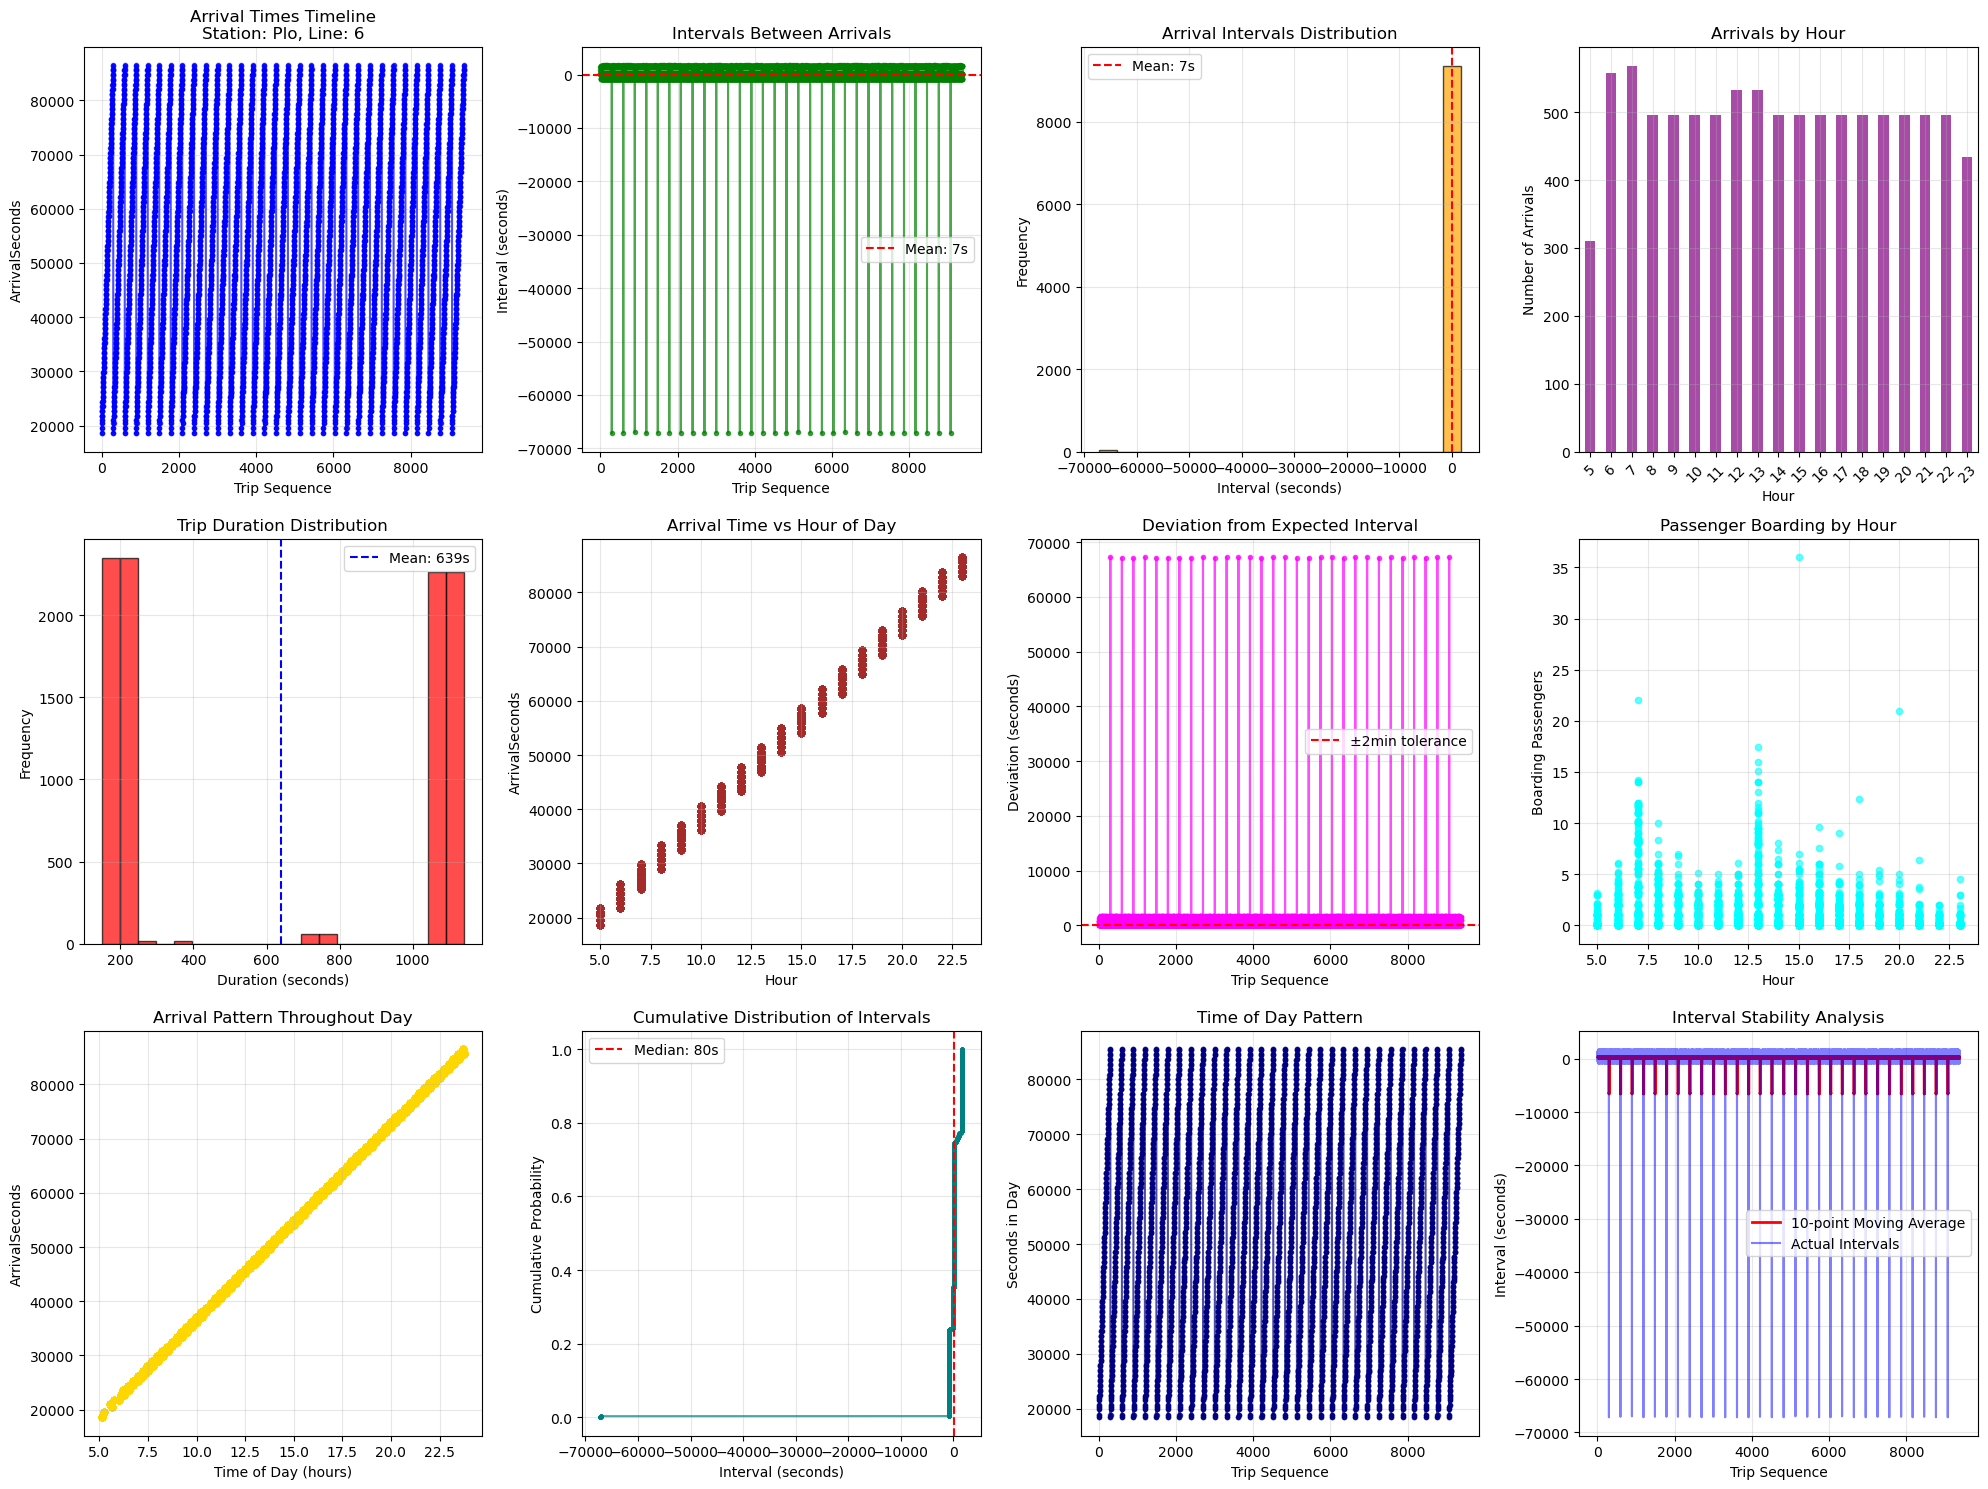


=== Á´ôÁÇπ Plo Á∫øË∑Ø 6 ÁªüËÆ°ÂàÜÊûê ===
ÊÄªËÆ∞ÂΩïÊï∞: 9382
Êó∂Èó¥Ë∑®Â∫¶: 2024-01-01 00:00:00 Âà∞ 2024-01-31 00:00:00
Âπ≥ÂùáÂà∞ËææÈó¥Èöî: 7.2 Áßí (0.1 ÂàÜÈíü)
Èó¥ÈöîÊ†áÂáÜÂ∑Æ: 3899.2 Áßí
Èó¥ÈöîÂèòÂºÇÁ≥ªÊï∞: 544.569
ÊúÄÁü≠Èó¥Èöî: -67170 Áßí
ÊúÄÈïøÈó¥Èöî: 1770 Áßí
‰∏≠‰ΩçÈó¥Èöî: 80 Áßí

Èó¥ÈöîÂáÜÁÇπÁéá (¬±120Áßí): 39.4%

ËøêËê•Êó∂Èó¥Ê®°Âºè:
   5ÁÇπ: 310 Áè≠Ê¨°
   6ÁÇπ: 558 Áè≠Ê¨°
   7ÁÇπ: 568 Áè≠Ê¨°
   8ÁÇπ: 496 Áè≠Ê¨°
   9ÁÇπ: 496 Áè≠Ê¨°
  10ÁÇπ: 496 Áè≠Ê¨°
  11ÁÇπ: 496 Áè≠Ê¨°
  12ÁÇπ: 532 Áè≠Ê¨°
  13ÁÇπ: 532 Áè≠Ê¨°
  14ÁÇπ: 496 Áè≠Ê¨°
  15ÁÇπ: 496 Áè≠Ê¨°
  16ÁÇπ: 496 Áè≠Ê¨°
  17ÁÇπ: 496 Áè≠Ê¨°
  18ÁÇπ: 496 Áè≠Ê¨°
  19ÁÇπ: 496 Áè≠Ê¨°
  20ÁÇπ: 496 Áè≠Ê¨°
  21ÁÇπ: 496 Áè≠Ê¨°
  22ÁÇπ: 496 Áè≠Ê¨°
  23ÁÇπ: 434 Áè≠Ê¨°


In [11]:
# ÈÄâÊã©‰∏Ä‰∏™Á´ôÁÇπÂíå‰∏ÄÊù°Á∫øË∑ØËøõË°åËØ¶ÁªÜÂàÜÊûê
print("=== ÈÄâÊã©Á´ôÁÇπÂíåÁ∫øË∑Ø ===")

# Êü•ÁúãÊúÄÊ¥ªË∑ÉÁöÑÁ´ôÁÇπÂíåÁ∫øË∑ØÁªÑÂêà
station_line_combo = df_clean.groupby(['StationCode', 'LineNumber']).size().reset_index(name='Count')
station_line_combo = station_line_combo.sort_values('Count', ascending=False)

print("ËÆ∞ÂΩïÊï∞ÊúÄÂ§öÁöÑÁ´ôÁÇπ-Á∫øË∑ØÁªÑÂêà:")
print(station_line_combo.head(10))

# ÈÄâÊã©ËÆ∞ÂΩïÊúÄÂ§öÁöÑÁªÑÂêà
top_station = station_line_combo.iloc[0]['StationCode']
top_line = station_line_combo.iloc[0]['LineNumber']

print(f"\nÈÄâÊã©ÂàÜÊûê: Á´ôÁÇπ {top_station}, Á∫øË∑Ø {top_line}")

# Á≠õÈÄâËøô‰∏™Á´ôÁÇπÂíåÁ∫øË∑ØÁöÑÊï∞ÊçÆ
station_line_data = df_clean[
    (df_clean['StationCode'] == top_station) & 
    (df_clean['LineNumber'] == top_line)
].copy()

print(f"ËØ•Á´ôÁÇπ-Á∫øË∑ØÁªÑÂêàÁöÑËÆ∞ÂΩïÊï∞: {len(station_line_data)}")

# ÊåâÊó∂Èó¥ÊéíÂ∫è
station_line_data = station_line_data.sort_values('TripStart')

plt.figure(figsize=(20, 15))

# 1. ËØ•Á´ôÁÇπËØ•Á∫øË∑ØÁöÑÂà∞ËææÊó∂Èó¥Â∫èÂàó
plt.subplot(3, 4, 1)
plt.plot(range(len(station_line_data)), station_line_data['ArrivalSeconds'], 
         marker='o', markersize=3, alpha=0.7, color='blue')
plt.title(f'Arrival Times Timeline\nStation: {top_station}, Line: {top_line}')
plt.xlabel('Trip Sequence')
plt.ylabel('ArrivalSeconds')
plt.grid(True, alpha=0.3)

# 2. ËÆ°ÁÆóÊó∂Èó¥Èó¥Èöî
arrival_intervals = np.diff(station_line_data['ArrivalSeconds'])
plt.subplot(3, 4, 2)
plt.plot(arrival_intervals, marker='o', markersize=3, alpha=0.7, color='green')
plt.title('Intervals Between Arrivals')
plt.xlabel('Trip Sequence')
plt.ylabel('Interval (seconds)')
plt.axhline(y=np.mean(arrival_intervals), color='red', linestyle='--', label=f'Mean: {np.mean(arrival_intervals):.0f}s')
plt.legend()
plt.grid(True, alpha=0.3)

# 3. Èó¥ÈöîÂàÜÂ∏ÉÁõ¥ÊñπÂõæ
plt.subplot(3, 4, 3)
plt.hist(arrival_intervals, bins=20, alpha=0.7, color='orange', edgecolor='black')
plt.title('Arrival Intervals Distribution')
plt.xlabel('Interval (seconds)')
plt.ylabel('Frequency')
plt.axvline(x=np.mean(arrival_intervals), color='red', linestyle='--', label=f'Mean: {np.mean(arrival_intervals):.0f}s')
plt.legend()
plt.grid(True, alpha=0.3)

# 4. ÊåâÂ∞èÊó∂ÂàÜÊûêÂà∞ËææÊ®°Âºè
station_line_data['Hour'] = station_line_data['TripStart'].dt.hour
hourly_pattern = station_line_data.groupby('Hour').size()
plt.subplot(3, 4, 4)
hourly_pattern.plot(kind='bar', alpha=0.7, color='purple')
plt.title('Arrivals by Hour')
plt.xlabel('Hour')
plt.ylabel('Number of Arrivals')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# 5. Ë°åÁ®ãÊó∂Èó¥ÂàÜÊûê
plt.subplot(3, 4, 5)
plt.hist(station_line_data['DelaySeconds'], bins=20, alpha=0.7, color='red', edgecolor='black')
plt.title('Trip Duration Distribution')
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.axvline(x=np.mean(station_line_data['DelaySeconds']), color='blue', linestyle='--', 
            label=f'Mean: {np.mean(station_line_data["DelaySeconds"]):.0f}s')
plt.legend()
plt.grid(True, alpha=0.3)

# 6. Âà∞ËææÊó∂Èó¥ vs Â∞èÊó∂ÁöÑÊï£ÁÇπÂõæ
plt.subplot(3, 4, 6)
plt.scatter(station_line_data['Hour'], station_line_data['ArrivalSeconds'], 
           alpha=0.6, s=20, color='brown')
plt.title('Arrival Time vs Hour of Day')
plt.xlabel('Hour')
plt.ylabel('ArrivalSeconds')
plt.grid(True, alpha=0.3)

# 7. ËÆ°ÁÆóÂáÜÁÇπÊÄßÔºàÂü∫‰∫éÈó¥ÈöîÁöÑËßÑÂæãÊÄßÔºâ
expected_interval = np.median(arrival_intervals)  # ‰øÆÊ≠£Ôºö‰ΩøÁî®np.median()
plt.subplot(3, 4, 7)
interval_deviation = np.abs(arrival_intervals - expected_interval)
plt.plot(interval_deviation, marker='o', markersize=3, alpha=0.7, color='magenta')
plt.title('Deviation from Expected Interval')
plt.xlabel('Trip Sequence')
plt.ylabel('Deviation (seconds)')
plt.axhline(y=120, color='red', linestyle='--', label='¬±2min tolerance')
plt.legend()
plt.grid(True, alpha=0.3)

# 8. ‰πòÂÆ¢ÊµÅÈáèÊ®°Âºè
plt.subplot(3, 4, 8)
total_boarding = station_line_data['Board1stClass'] + station_line_data['Board2ndClass']
plt.scatter(station_line_data['Hour'], total_boarding, alpha=0.6, s=20, color='cyan')
plt.title('Passenger Boarding by Hour')
plt.xlabel('Hour')
plt.ylabel('Boarding Passengers')
plt.grid(True, alpha=0.3)

# 9. Êó∂Èó¥Â∫èÂàóÔºöÂà∞ËææÊó∂Èó¥ÁöÑÊó•ÂÜÖÂèòÂåñ
plt.subplot(3, 4, 9)
station_line_data['TimeOfDay'] = station_line_data['TripStart'].dt.hour + station_line_data['TripStart'].dt.minute/60
plt.scatter(station_line_data['TimeOfDay'], station_line_data['ArrivalSeconds'], 
           alpha=0.6, s=20, color='gold')
plt.title('Arrival Pattern Throughout Day')
plt.xlabel('Time of Day (hours)')
plt.ylabel('ArrivalSeconds')
plt.grid(True, alpha=0.3)

# 10. Èó¥ÈöîÁöÑÁ¥ØÁßØÂàÜÂ∏É
plt.subplot(3, 4, 10)
sorted_intervals = np.sort(arrival_intervals)
cumulative = np.arange(1, len(sorted_intervals) + 1) / len(sorted_intervals)
plt.plot(sorted_intervals, cumulative, marker='o', markersize=2, alpha=0.7, color='teal')
plt.title('Cumulative Distribution of Intervals')
plt.xlabel('Interval (seconds)')
plt.ylabel('Cumulative Probability')
plt.axvline(x=expected_interval, color='red', linestyle='--', label=f'Median: {expected_interval:.0f}s')
plt.legend()
plt.grid(True, alpha=0.3)

# 11. Ê£ÄÊü•ÊòØÂê¶ÊúâËßÑÂæãÁöÑÊó∂ÂàªË°®
plt.subplot(3, 4, 11)
station_line_data['SecondInDay'] = (station_line_data['TripStart'].dt.hour * 3600 + 
                                   station_line_data['TripStart'].dt.minute * 60 + 
                                   station_line_data['TripStart'].dt.second)
plt.plot(range(len(station_line_data)), station_line_data['SecondInDay'], 
         marker='o', markersize=3, alpha=0.7, color='navy')
plt.title('Time of Day Pattern')
plt.xlabel('Trip Sequence')
plt.ylabel('Seconds in Day')
plt.grid(True, alpha=0.3)

# 12. Èó¥ÈöîÁ®≥ÂÆöÊÄßÂàÜÊûê
plt.subplot(3, 4, 12)
window = min(10, len(arrival_intervals)//2)
if len(arrival_intervals) >= window:
    moving_avg = np.convolve(arrival_intervals, np.ones(window)/window, mode='valid')
    plt.plot(range(window-1, len(arrival_intervals)), moving_avg, 
             label=f'{window}-point Moving Average', color='red', linewidth=2)
plt.plot(arrival_intervals, alpha=0.5, label='Actual Intervals', color='blue')
plt.title('Interval Stability Analysis')
plt.xlabel('Trip Sequence')
plt.ylabel('Interval (seconds)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ÁªüËÆ°ÂàÜÊûê
print(f"\n=== Á´ôÁÇπ {top_station} Á∫øË∑Ø {top_line} ÁªüËÆ°ÂàÜÊûê ===")
print(f"ÊÄªËÆ∞ÂΩïÊï∞: {len(station_line_data)}")
print(f"Êó∂Èó¥Ë∑®Â∫¶: {station_line_data['Date'].min()} Âà∞ {station_line_data['Date'].max()}")
print(f"Âπ≥ÂùáÂà∞ËææÈó¥Èöî: {np.mean(arrival_intervals):.1f} Áßí ({np.mean(arrival_intervals)/60:.1f} ÂàÜÈíü)")
print(f"Èó¥ÈöîÊ†áÂáÜÂ∑Æ: {np.std(arrival_intervals):.1f} Áßí")
print(f"Èó¥ÈöîÂèòÂºÇÁ≥ªÊï∞: {np.std(arrival_intervals)/np.mean(arrival_intervals):.3f}")
print(f"ÊúÄÁü≠Èó¥Èöî: {np.min(arrival_intervals):.0f} Áßí")
print(f"ÊúÄÈïøÈó¥Èöî: {np.max(arrival_intervals):.0f} Áßí")
print(f"‰∏≠‰ΩçÈó¥Èöî: {np.median(arrival_intervals):.0f} Áßí")

# ÂáÜÁÇπÊÄßÂàÜÊûêÔºàÂü∫‰∫éÈó¥ÈöîËßÑÂæãÊÄßÔºâ
tolerance = 120  # 2ÂàÜÈíüÂÆπÂøçÂ∫¶
on_time_intervals = np.abs(arrival_intervals - np.median(arrival_intervals)) <= tolerance
print(f"\nÈó¥ÈöîÂáÜÁÇπÁéá (¬±{tolerance}Áßí): {np.mean(on_time_intervals)*100:.1f}%")

print(f"\nËøêËê•Êó∂Èó¥Ê®°Âºè:")
for hour, count in hourly_pattern.items():
    print(f"  {hour:2d}ÁÇπ: {count:2d} Áè≠Ê¨°")

=== ‰∏ìÈó®ÂàÜÊûêÔºöÁ´ôÁÇπ Plo, Á∫øË∑Ø 6 ===
ËÆ∞ÂΩïÊï∞: 9382


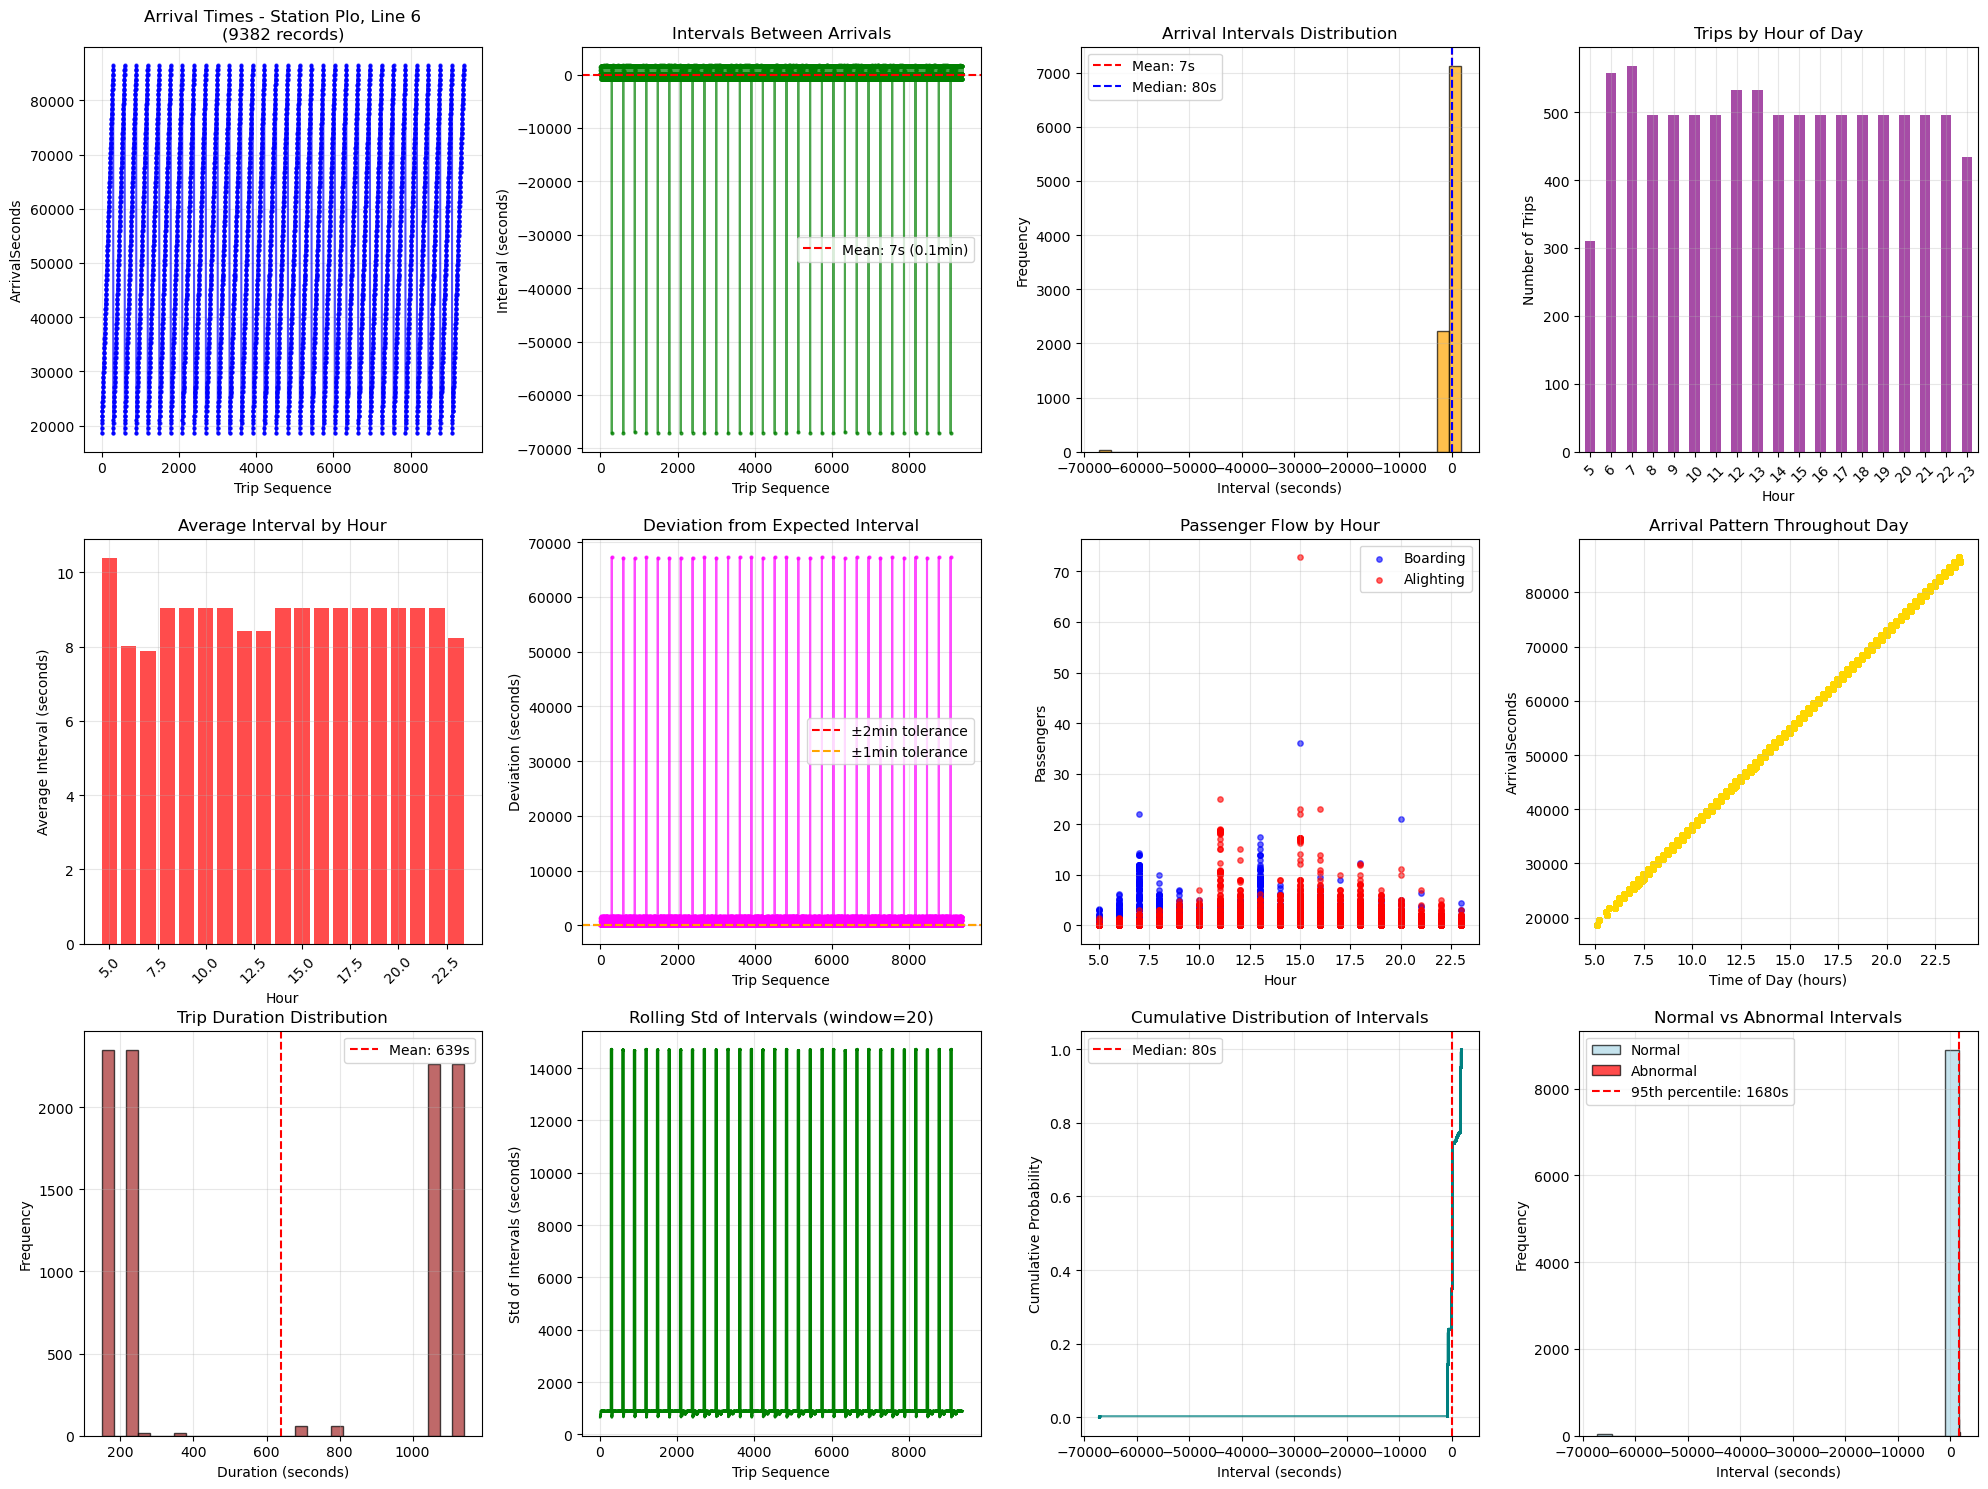


=== Á´ôÁÇπ Plo Á∫øË∑Ø 6 ËØ¶ÁªÜÁªüËÆ° ===
ÂàÜÊûêÊúüÈó¥: 2024-01-01 00:00:00 Âà∞ 2024-01-31 00:00:00
ÊÄªÁè≠Ê¨°: 9382
ÊÄªÈó¥ÈöîÊï∞: 9381

üìä Èó¥ÈöîÁªüËÆ°:
  Âπ≥ÂùáÈó¥Èöî: 7.2 Áßí (0.1 ÂàÜÈíü)
  ‰∏≠‰ΩçÈó¥Èöî: 80.0 Áßí (1.3 ÂàÜÈíü)
  Ê†áÂáÜÂ∑Æ: 3899.2 Áßí
  ÂèòÂºÇÁ≥ªÊï∞: 544.569
  ÊúÄÁü≠Èó¥Èöî: -67170 Áßí (-1119.5 ÂàÜÈíü)
  ÊúÄÈïøÈó¥Èöî: 1770 Áßí (29.5 ÂàÜÈíü)

‚è∞ ÊúçÂä°Êó∂Èó¥:
  È¶ñÁè≠: 05:07:01
  Êú´Áè≠: 23:45:00
  ËøêËê•Êó∂Èïø: 738.6 Â∞èÊó∂

üéØ ÂáÜÁÇπÊÄßÂàÜÊûê:
  Èó¥ÈöîÂáÜÁÇπÁéá (¬±1ÂàÜÈíü): 39.3%
  Èó¥ÈöîÂáÜÁÇπÁéá (¬±2ÂàÜÈíü): 39.4%
  Èó¥ÈöîÂáÜÁÇπÁéá (¬±5ÂàÜÈíü): 50.3%

üöå ‰πòÂÆ¢ÊµÅÈáè:
  ÊÄª‰∏äËΩ¶‰∫∫Êï∞: 6054
  ÊÄª‰∏ãËΩ¶‰∫∫Êï∞: 5531
  Âπ≥ÂùáÊØèÁè≠‰∏äËΩ¶: 0.6 ‰∫∫
  Âπ≥ÂùáÊØèÁè≠‰∏ãËΩ¶: 0.6 ‰∫∫

üîç ÊúçÂä°Ë¥®ÈáèËØÑ‰º∞:
  ‚ö†Ô∏è Áè≠Ê¨°Èó¥Èöî‰∏çÂ§üËßÑÂæã
  ‚ùå ÂáÜÁÇπÁéáËæÉÂ∑Æ


In [12]:
# ‰∏ìÈó®ÂàÜÊûêÁ´ôÁÇπPloÔºåÁ∫øË∑Ø6
selected_station = 'Plo'
selected_line = 6

print(f"=== ‰∏ìÈó®ÂàÜÊûêÔºöÁ´ôÁÇπ {selected_station}, Á∫øË∑Ø {selected_line} ===")

# Á≠õÈÄâÊï∞ÊçÆ
plo_line6_data = df_clean[
    (df_clean['StationCode'] == selected_station) & 
    (df_clean['LineNumber'] == selected_line)
].copy()

print(f"ËÆ∞ÂΩïÊï∞: {len(plo_line6_data)}")

# ÊåâÊó∂Èó¥ÊéíÂ∫è
plo_line6_data = plo_line6_data.sort_values('TripStart')

plt.figure(figsize=(20, 15))

# 1. Âà∞ËææÊó∂Èó¥Â∫èÂàó
plt.subplot(3, 4, 1)
plt.plot(range(len(plo_line6_data)), plo_line6_data['ArrivalSeconds'], 
         marker='o', markersize=2, alpha=0.7, color='blue')
plt.title(f'Arrival Times - Station Plo, Line 6\n({len(plo_line6_data)} records)')
plt.xlabel('Trip Sequence')
plt.ylabel('ArrivalSeconds')
plt.grid(True, alpha=0.3)

# 2. ËÆ°ÁÆóÂà∞ËææÈó¥Èöî
arrival_intervals = np.diff(plo_line6_data['ArrivalSeconds'])
plt.subplot(3, 4, 2)
plt.plot(arrival_intervals, marker='o', markersize=2, alpha=0.7, color='green')
plt.title('Intervals Between Arrivals')
plt.xlabel('Trip Sequence')
plt.ylabel('Interval (seconds)')
plt.axhline(y=np.mean(arrival_intervals), color='red', linestyle='--', 
            label=f'Mean: {np.mean(arrival_intervals):.0f}s ({np.mean(arrival_intervals)/60:.1f}min)')
plt.legend()
plt.grid(True, alpha=0.3)

# 3. Èó¥ÈöîÂàÜÂ∏É
plt.subplot(3, 4, 3)
plt.hist(arrival_intervals, bins=30, alpha=0.7, color='orange', edgecolor='black')
plt.title('Arrival Intervals Distribution')
plt.xlabel('Interval (seconds)')
plt.ylabel('Frequency')
plt.axvline(x=np.mean(arrival_intervals), color='red', linestyle='--', label=f'Mean: {np.mean(arrival_intervals):.0f}s')
plt.axvline(x=np.median(arrival_intervals), color='blue', linestyle='--', label=f'Median: {np.median(arrival_intervals):.0f}s')
plt.legend()
plt.grid(True, alpha=0.3)

# 4. ÊåâÂ∞èÊó∂ÁöÑÁè≠Ê¨°ÂàÜÂ∏É
plo_line6_data['Hour'] = plo_line6_data['TripStart'].dt.hour
hourly_pattern = plo_line6_data.groupby('Hour').size()
plt.subplot(3, 4, 4)
hourly_pattern.plot(kind='bar', alpha=0.7, color='purple')
plt.title('Trips by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Number of Trips')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# 5. ÊåâÂ∞èÊó∂ÁöÑÂπ≥ÂùáÈó¥Èöî
plt.subplot(3, 4, 5)
hourly_intervals = []
hourly_labels = []
for hour in sorted(hourly_pattern.index):
    hour_data = plo_line6_data[plo_line6_data['Hour'] == hour].sort_values('ArrivalSeconds')
    if len(hour_data) > 1:
        hour_intervals = np.diff(hour_data['ArrivalSeconds'])
        hourly_intervals.append(np.mean(hour_intervals))
        hourly_labels.append(hour)

plt.bar(hourly_labels, hourly_intervals, alpha=0.7, color='red')
plt.title('Average Interval by Hour')
plt.xlabel('Hour')
plt.ylabel('Average Interval (seconds)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# 6. ÂáÜÁÇπÊÄßÂàÜÊûêÔºàÈó¥ÈöîÂÅèÂ∑ÆÔºâ
plt.subplot(3, 4, 6)
expected_interval = np.median(arrival_intervals)
interval_deviation = np.abs(arrival_intervals - expected_interval)
plt.plot(interval_deviation, marker='o', markersize=2, alpha=0.7, color='magenta')
plt.title('Deviation from Expected Interval')
plt.xlabel('Trip Sequence')
plt.ylabel('Deviation (seconds)')
plt.axhline(y=120, color='red', linestyle='--', label='¬±2min tolerance')
plt.axhline(y=60, color='orange', linestyle='--', label='¬±1min tolerance')
plt.legend()
plt.grid(True, alpha=0.3)

# 7. ‰πòÂÆ¢ÊµÅÈáè
plt.subplot(3, 4, 7)
total_boarding = plo_line6_data['Board1stClass'] + plo_line6_data['Board2ndClass']
total_alighting = plo_line6_data['Alight1stClass'] + plo_line6_data['Alight2ndClass']
plt.scatter(plo_line6_data['Hour'], total_boarding, alpha=0.6, s=15, color='blue', label='Boarding')
plt.scatter(plo_line6_data['Hour'], total_alighting, alpha=0.6, s=15, color='red', label='Alighting')
plt.title('Passenger Flow by Hour')
plt.xlabel('Hour')
plt.ylabel('Passengers')
plt.legend()
plt.grid(True, alpha=0.3)

# 8. ‰∏ÄÂ§©‰∏≠ÁöÑÂà∞ËææÊ®°Âºè
plt.subplot(3, 4, 8)
plo_line6_data['TimeOfDay'] = (plo_line6_data['TripStart'].dt.hour + 
                               plo_line6_data['TripStart'].dt.minute/60)
plt.scatter(plo_line6_data['TimeOfDay'], plo_line6_data['ArrivalSeconds'], 
           alpha=0.6, s=15, color='gold')
plt.title('Arrival Pattern Throughout Day')
plt.xlabel('Time of Day (hours)')
plt.ylabel('ArrivalSeconds')
plt.grid(True, alpha=0.3)

# 9. Ë°åÁ®ãÊó∂Èó¥ÂàÜÊûê
plt.subplot(3, 4, 9)
plt.hist(plo_line6_data['DelaySeconds'], bins=30, alpha=0.7, color='brown', edgecolor='black')
plt.title('Trip Duration Distribution')
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.axvline(x=np.mean(plo_line6_data['DelaySeconds']), color='red', linestyle='--', 
            label=f'Mean: {np.mean(plo_line6_data["DelaySeconds"]):.0f}s')
plt.legend()
plt.grid(True, alpha=0.3)

# 10. Èó¥ÈöîÂèòÂºÇÊÄßÈöèÊó∂Èó¥ÂèòÂåñ
plt.subplot(3, 4, 10)
window = 20  # 20‰∏™Áè≠Ê¨°ÁöÑÊªëÂä®Á™óÂè£
if len(arrival_intervals) >= window:
    rolling_std = []
    for i in range(window, len(arrival_intervals)):
        window_data = arrival_intervals[i-window:i]
        rolling_std.append(np.std(window_data))
    
    plt.plot(range(window, len(arrival_intervals)), rolling_std, color='green', linewidth=2)
    plt.title(f'Rolling Std of Intervals (window={window})')
    plt.xlabel('Trip Sequence')
    plt.ylabel('Std of Intervals (seconds)')
    plt.grid(True, alpha=0.3)

# 11. Á¥ØÁßØÂàÜÂ∏ÉÂáΩÊï∞
plt.subplot(3, 4, 11)
sorted_intervals = np.sort(arrival_intervals)
cumulative = np.arange(1, len(sorted_intervals) + 1) / len(sorted_intervals)
plt.plot(sorted_intervals, cumulative, marker='o', markersize=1, alpha=0.7, color='teal')
plt.title('Cumulative Distribution of Intervals')
plt.xlabel('Interval (seconds)')
plt.ylabel('Cumulative Probability')
plt.axvline(x=np.median(arrival_intervals), color='red', linestyle='--', 
            label=f'Median: {np.median(arrival_intervals):.0f}s')
plt.grid(True, alpha=0.3)
plt.legend()

# 12. ÂèëÁé∞ÂºÇÂ∏∏Èó¥Èöî
plt.subplot(3, 4, 12)
# Ê†áËÆ∞ÂºÇÂ∏∏ÈïøÁöÑÈó¥Èöî
threshold = np.percentile(arrival_intervals, 95)  # 95ÁôæÂàÜ‰ΩçÊï∞‰Ωú‰∏∫ÂºÇÂ∏∏ÈòàÂÄº
normal_intervals = arrival_intervals[arrival_intervals <= threshold]
abnormal_intervals = arrival_intervals[arrival_intervals > threshold]

plt.hist(normal_intervals, bins=25, alpha=0.7, color='lightblue', label='Normal', edgecolor='black')
plt.hist(abnormal_intervals, bins=10, alpha=0.7, color='red', label='Abnormal', edgecolor='black')
plt.title('Normal vs Abnormal Intervals')
plt.xlabel('Interval (seconds)')
plt.ylabel('Frequency')
plt.axvline(x=threshold, color='red', linestyle='--', label=f'95th percentile: {threshold:.0f}s')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ËØ¶ÁªÜÁªüËÆ°ÂàÜÊûê
print(f"\n=== Á´ôÁÇπ Plo Á∫øË∑Ø 6 ËØ¶ÁªÜÁªüËÆ° ===")
print(f"ÂàÜÊûêÊúüÈó¥: {plo_line6_data['Date'].min()} Âà∞ {plo_line6_data['Date'].max()}")
print(f"ÊÄªÁè≠Ê¨°: {len(plo_line6_data)}")
print(f"ÊÄªÈó¥ÈöîÊï∞: {len(arrival_intervals)}")

print(f"\nüìä Èó¥ÈöîÁªüËÆ°:")
print(f"  Âπ≥ÂùáÈó¥Èöî: {np.mean(arrival_intervals):.1f} Áßí ({np.mean(arrival_intervals)/60:.1f} ÂàÜÈíü)")
print(f"  ‰∏≠‰ΩçÈó¥Èöî: {np.median(arrival_intervals):.1f} Áßí ({np.median(arrival_intervals)/60:.1f} ÂàÜÈíü)")
print(f"  Ê†áÂáÜÂ∑Æ: {np.std(arrival_intervals):.1f} Áßí")
print(f"  ÂèòÂºÇÁ≥ªÊï∞: {np.std(arrival_intervals)/np.mean(arrival_intervals):.3f}")
print(f"  ÊúÄÁü≠Èó¥Èöî: {np.min(arrival_intervals):.0f} Áßí ({np.min(arrival_intervals)/60:.1f} ÂàÜÈíü)")
print(f"  ÊúÄÈïøÈó¥Èöî: {np.max(arrival_intervals):.0f} Áßí ({np.max(arrival_intervals)/60:.1f} ÂàÜÈíü)")

print(f"\n‚è∞ ÊúçÂä°Êó∂Èó¥:")
print(f"  È¶ñÁè≠: {plo_line6_data['TripStart'].min().strftime('%H:%M:%S')}")
print(f"  Êú´Áè≠: {plo_line6_data['TripStart'].max().strftime('%H:%M:%S')}")
print(f"  ËøêËê•Êó∂Èïø: {(plo_line6_data['TripStart'].max() - plo_line6_data['TripStart'].min()).total_seconds()/3600:.1f} Â∞èÊó∂")

print(f"\nüéØ ÂáÜÁÇπÊÄßÂàÜÊûê:")
tolerance_1min = np.sum(np.abs(arrival_intervals - np.median(arrival_intervals)) <= 60) / len(arrival_intervals) * 100
tolerance_2min = np.sum(np.abs(arrival_intervals - np.median(arrival_intervals)) <= 120) / len(arrival_intervals) * 100
tolerance_5min = np.sum(np.abs(arrival_intervals - np.median(arrival_intervals)) <= 300) / len(arrival_intervals) * 100

print(f"  Èó¥ÈöîÂáÜÁÇπÁéá (¬±1ÂàÜÈíü): {tolerance_1min:.1f}%")
print(f"  Èó¥ÈöîÂáÜÁÇπÁéá (¬±2ÂàÜÈíü): {tolerance_2min:.1f}%")
print(f"  Èó¥ÈöîÂáÜÁÇπÁéá (¬±5ÂàÜÈíü): {tolerance_5min:.1f}%")

print(f"\nüöå ‰πòÂÆ¢ÊµÅÈáè:")
total_board = plo_line6_data['Board1stClass'].sum() + plo_line6_data['Board2ndClass'].sum()
total_alight = plo_line6_data['Alight1stClass'].sum() + plo_line6_data['Alight2ndClass'].sum()
print(f"  ÊÄª‰∏äËΩ¶‰∫∫Êï∞: {total_board:.0f}")
print(f"  ÊÄª‰∏ãËΩ¶‰∫∫Êï∞: {total_alight:.0f}")
print(f"  Âπ≥ÂùáÊØèÁè≠‰∏äËΩ¶: {total_board/len(plo_line6_data):.1f} ‰∫∫")
print(f"  Âπ≥ÂùáÊØèÁè≠‰∏ãËΩ¶: {total_alight/len(plo_line6_data):.1f} ‰∫∫")

print(f"\nüîç ÊúçÂä°Ë¥®ÈáèËØÑ‰º∞:")
if np.std(arrival_intervals)/np.mean(arrival_intervals) < 0.3:
    print("  ‚úÖ Áè≠Ê¨°Èó¥ÈöîËæÉ‰∏∫ËßÑÂæã")
else:
    print("  ‚ö†Ô∏è Áè≠Ê¨°Èó¥Èöî‰∏çÂ§üËßÑÂæã")

if tolerance_2min > 80:
    print("  ‚úÖ ÂáÜÁÇπÁéáËâØÂ•Ω")
elif tolerance_2min > 60:
    print("  ‚ö†Ô∏è ÂáÜÁÇπÁéá‰∏ÄËà¨")
else:
    print("  ‚ùå ÂáÜÁÇπÁéáËæÉÂ∑Æ")

In [13]:
plo_line6_data['TripStartSeconds']



593746    18421
593748    18421
593775    18781
593777    18781
593800    19920
          ...  
696710    84600
696740    85380
696742    85380
696752    85500
696754    85500
Name: TripStartSeconds, Length: 9382, dtype: int64

In [14]:
plo_line6_data['ArrivalSeconds']

593746    18570.0
593748    18660.0
593775    19480.0
593777    19560.0
593800    20980.0
           ...   
696710    84840.0
696740    86440.0
696742    86520.0
696752    85650.0
696754    85740.0
Name: ArrivalSeconds, Length: 9382, dtype: float64

In [15]:
print(plo_line6_data)

             Date   ShortName  TrainNumber  TripNumber  TripType  \
593746 2024-01-01         dim        66004       66004         1   
593748 2024-01-01         dim        66004       66004         1   
593775 2024-01-01         dim        66003       66003         1   
593777 2024-01-01         dim        66003       66003         1   
593800 2024-01-01         dim        66011       66011         1   
...           ...         ...          ...         ...       ...   
696710 2024-01-31  lu-ve-scol        66584       66584         1   
696740 2024-01-31  lu-ve-scol        66595       66595         1   
696742 2024-01-31  lu-ve-scol        66595       66595         1   
696752 2024-01-31  lu-ve-scol        66596       66596         1   
696754 2024-01-31  lu-ve-scol        66596       66596         1   

        TripStartSeconds  TripEndSeconds           TripStart  \
593746             18421           19800 2024-01-01 05:07:01   
593748             18421           19800 2024-01-01 05:

=== PloÁ´ô6Âè∑Á∫øÊ∑±Â∫¶ÂàÜÊûê ===
Êï∞ÊçÆÊ¶ÇÂÜµ: 9382 Êù°ËÆ∞ÂΩïÔºåÊó∂Èó¥Ë∑®Â∫¶: 2024-01-01 00:00:00 Âà∞ 2024-01-31 00:00:00


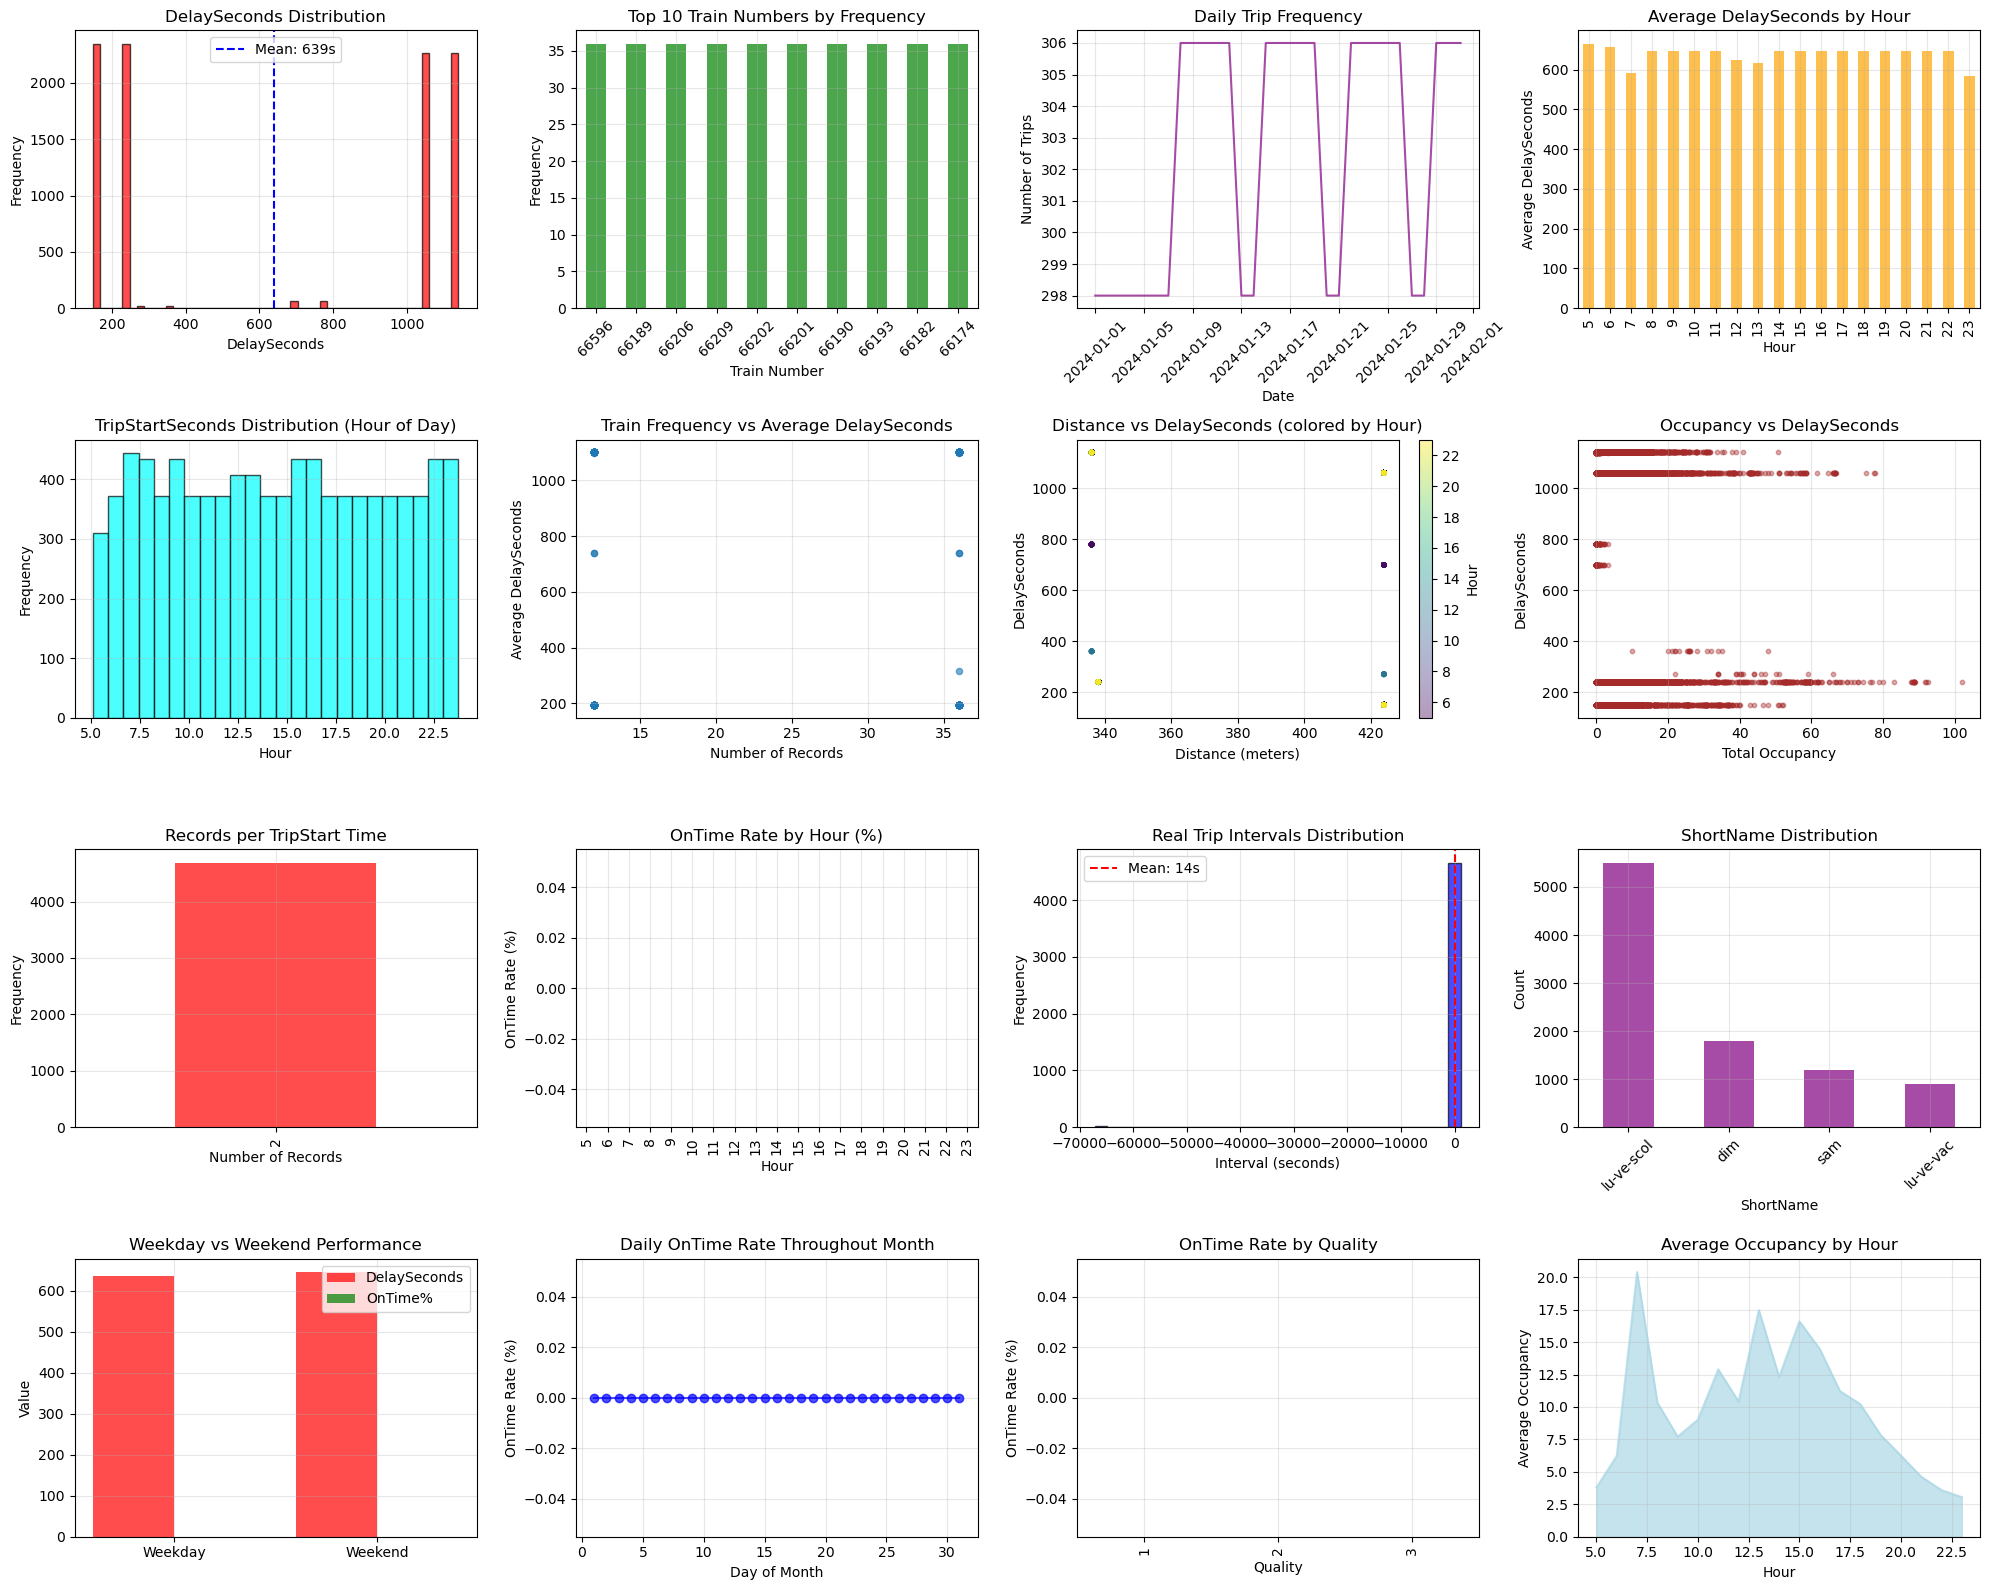


=== ÂÖ≥ÈîÆÂèëÁé∞ ===

üìä Âü∫Êú¨ÁªüËÆ°:
  DelaySecondsÂùáÂÄº: 639.2Áßí (10.7ÂàÜÈíü)
  DelaySeconds‰∏≠‰ΩçÊï∞: 240.0Áßí
  ÊÄª‰ΩìÂáÜÁÇπÁéá: 0.0%

üöå ËΩ¶Ê¨°ÂàÜÊûê:
  ‰∏çÂêåËΩ¶Ê¨°Êï∞: 600
  ÊúÄÈ¢ëÁπÅËΩ¶Ê¨°: 66001 (Âá∫Áé∞36Ê¨°)

‚è∞ Êó∂Èó¥Ê®°Âºè:
  ÂáÜÁÇπÁéáÊúÄÈ´òÊó∂ÊÆµ: 5ÁÇπ (0.0%)
  ÂáÜÁÇπÁéáÊúÄ‰ΩéÊó∂ÊÆµ: 5ÁÇπ (0.0%)

üîç Êï∞ÊçÆË¥®Èáè:
  ÈáçÂ§çÊó∂Èó¥ËÆ∞ÂΩï: 4691Êù° (50.0%)

üìà ÁúüÂÆûÁè≠Ê¨°Èó¥Èöî:
  Âπ≥ÂùáÈó¥Èöî: 14.3Áßí (0.2ÂàÜÈíü)
  Èó¥ÈöîÊ†áÂáÜÂ∑Æ: 5393.1Áßí
  ÊúÄÁü≠Èó¥Èöî: -67079Áßí
  ÊúÄÈïøÈó¥Èöî: 1139Áßí

üéØ ÊúçÂä°Ê®°Âºè:
  ‚ùå ÂáÜÁÇπÁéáÈúÄË¶ÅÊîπÂñÑ
  ‚ö†Ô∏è Áè≠Ê¨°Èó¥ÈöîÂèòÂåñËæÉÂ§ß


In [16]:
print("=== PloÁ´ô6Âè∑Á∫øÊ∑±Â∫¶ÂàÜÊûê ===")
print(f"Êï∞ÊçÆÊ¶ÇÂÜµ: {len(plo_line6_data)} Êù°ËÆ∞ÂΩïÔºåÊó∂Èó¥Ë∑®Â∫¶: {plo_line6_data['Date'].min()} Âà∞ {plo_line6_data['Date'].max()}")

plt.figure(figsize=(20, 16))

# 1. DelaySecondsÂàÜÊûê - Ëøô‰∏™Â≠óÊÆµÂæàÂÖ≥ÈîÆ
plt.subplot(4, 4, 1)
plt.hist(plo_line6_data['DelaySeconds'], bins=50, alpha=0.7, color='red', edgecolor='black')
plt.title('DelaySeconds Distribution')
plt.xlabel('DelaySeconds')
plt.ylabel('Frequency')
plt.axvline(plo_line6_data['DelaySeconds'].mean(), color='blue', linestyle='--', 
            label=f'Mean: {plo_line6_data["DelaySeconds"].mean():.0f}s')
plt.legend()
plt.grid(True, alpha=0.3)

# 2. Âêå‰∏ÄËΩ¶Ê¨°(TrainNumber)ÁöÑÊ®°ÂºèÂàÜÊûê
plt.subplot(4, 4, 2)
train_counts = plo_line6_data['TrainNumber'].value_counts().head(10)
train_counts.plot(kind='bar', alpha=0.7, color='green')
plt.title('Top 10 Train Numbers by Frequency')
plt.xlabel('Train Number')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# 3. ÊåâÊó•ÊúüÁöÑÁè≠Ê¨°ÂàÜÂ∏É
plt.subplot(4, 4, 3)
daily_trips = plo_line6_data.groupby(plo_line6_data['Date'].dt.date).size()
daily_trips.plot(kind='line', alpha=0.7, color='purple')
plt.title('Daily Trip Frequency')
plt.xlabel('Date')
plt.ylabel('Number of Trips')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# 4. DelaySeconds vs Hour ÁÉ≠ÂäõÂõæ
plt.subplot(4, 4, 4)
delay_by_hour = plo_line6_data.groupby('Hour')['DelaySeconds'].mean()
delay_by_hour.plot(kind='bar', alpha=0.7, color='orange')
plt.title('Average DelaySeconds by Hour')
plt.xlabel('Hour')
plt.ylabel('Average DelaySeconds')
plt.grid(True, alpha=0.3)

# 5. ÂàÜÊûêTripStartSecondsÁöÑËßÑÂæã
plt.subplot(4, 4, 5)
# ÁúãTripStartSecondsÂú®‰∏ÄÂ§©‰∏≠ÁöÑÂàÜÂ∏É
trip_start_hour = (plo_line6_data['TripStartSeconds'] % 86400) / 3600  # ËΩ¨Êç¢‰∏∫Â∞èÊó∂
plt.hist(trip_start_hour, bins=24, alpha=0.7, color='cyan', edgecolor='black')
plt.title('TripStartSeconds Distribution (Hour of Day)')
plt.xlabel('Hour')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# 6. ÊØè‰∏™ËΩ¶Ê¨°ÁöÑÂπ≥ÂùáDelaySeconds
plt.subplot(4, 4, 6)
train_delay = plo_line6_data.groupby('TrainNumber')['DelaySeconds'].agg(['mean', 'count'])
train_delay = train_delay[train_delay['count'] >= 10]  # Ëá≥Â∞ë10Ê¨°ËÆ∞ÂΩï
plt.scatter(train_delay['count'], train_delay['mean'], alpha=0.6, s=20)
plt.title('Train Frequency vs Average DelaySeconds')
plt.xlabel('Number of Records')
plt.ylabel('Average DelaySeconds')
plt.grid(True, alpha=0.3)

# 7. Ë∑ùÁ¶ªvs DelaySecondsÂÖ≥Á≥ª
plt.subplot(4, 4, 7)
plt.scatter(plo_line6_data['DistanceMeters'], plo_line6_data['DelaySeconds'], 
           alpha=0.4, s=10, c=plo_line6_data['Hour'], cmap='viridis')
plt.colorbar(label='Hour')
plt.title('Distance vs DelaySeconds (colored by Hour)')
plt.xlabel('Distance (meters)')
plt.ylabel('DelaySeconds')
plt.grid(True, alpha=0.3)

# 8. ‰πòÂÆ¢Âç†Áî®Áéávs DelaySeconds
plt.subplot(4, 4, 8)
plt.scatter(plo_line6_data['TotalOccupancy'], plo_line6_data['DelaySeconds'], 
           alpha=0.4, s=10, color='brown')
plt.title('Occupancy vs DelaySeconds')
plt.xlabel('Total Occupancy')
plt.ylabel('DelaySeconds')
plt.grid(True, alpha=0.3)

# 9. Âêå‰∏ÄÊó∂Èó¥Â§ö‰∏™ËÆ∞ÂΩïÁöÑÂàÜÊûê
plt.subplot(4, 4, 9)
time_duplicates = plo_line6_data.groupby('TripStart').size()
duplicate_counts = time_duplicates.value_counts()
duplicate_counts.plot(kind='bar', alpha=0.7, color='red')
plt.title('Records per TripStart Time')
plt.xlabel('Number of Records')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# 10. OnTimeÂ≠óÊÆµÂàÜÊûê
plt.subplot(4, 4, 10)
ontime_by_hour = plo_line6_data.groupby('Hour')['OnTime'].mean() * 100
ontime_by_hour.plot(kind='bar', alpha=0.7, color='green')
plt.title('OnTime Rate by Hour (%)')
plt.xlabel('Hour')
plt.ylabel('OnTime Rate (%)')
plt.grid(True, alpha=0.3)

# 11. ËÆ°ÁÆóÁúüÂÆûÁöÑÁè≠Ê¨°Èó¥Èöî
plt.subplot(4, 4, 11)
# ÊåâTripStartÊó∂Èó¥ÊéíÂ∫èÔºåËÆ°ÁÆóÁúüÂÆûÈó¥Èöî
sorted_data = plo_line6_data.sort_values('TripStart')
unique_trips = sorted_data.drop_duplicates(subset=['TripStart'])  # ÂéªÈô§ÈáçÂ§çÊó∂Èó¥
real_intervals = np.diff(unique_trips['TripStartSeconds'])
plt.hist(real_intervals, bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.title('Real Trip Intervals Distribution')
plt.xlabel('Interval (seconds)')
plt.ylabel('Frequency')
plt.axvline(np.mean(real_intervals), color='red', linestyle='--', 
            label=f'Mean: {np.mean(real_intervals):.0f}s')
plt.legend()
plt.grid(True, alpha=0.3)

# 12. ShortNameÊ®°ÂºèÂàÜÊûê
plt.subplot(4, 4, 12)
shortname_counts = plo_line6_data['ShortName'].value_counts()
shortname_counts.plot(kind='bar', alpha=0.7, color='purple')
plt.title('ShortName Distribution')
plt.xlabel('ShortName')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# 13. Â∑•‰ΩúÊó•vsÂë®Êú´ÂàÜÊûê
plt.subplot(4, 4, 13)
plo_line6_data['Weekday'] = plo_line6_data['Date'].dt.day_name()
plo_line6_data['IsWeekend'] = plo_line6_data['Date'].dt.weekday >= 5
weekend_analysis = plo_line6_data.groupby('IsWeekend').agg({
    'DelaySeconds': 'mean',
    'OnTime': 'mean',
    'TotalOccupancy': 'mean'
})
weekend_analysis['OnTime'] *= 100

x = [0, 1]
plt.bar([x[0]-0.2, x[1]-0.2], weekend_analysis['DelaySeconds'], width=0.4, 
        label='DelaySeconds', alpha=0.7, color='red')
plt.bar([x[0]+0.2, x[1]+0.2], weekend_analysis['OnTime'], width=0.4, 
        label='OnTime%', alpha=0.7, color='green')
plt.xticks(x, ['Weekday', 'Weekend'])
plt.title('Weekday vs Weekend Performance')
plt.ylabel('Value')
plt.legend()
plt.grid(True, alpha=0.3)

# 14. ÊúàÂ∫¶Ë∂ãÂäø
plt.subplot(4, 4, 14)
plo_line6_data['Day'] = plo_line6_data['Date'].dt.day
daily_ontime = plo_line6_data.groupby('Day')['OnTime'].mean() * 100
daily_ontime.plot(kind='line', alpha=0.7, color='blue', marker='o')
plt.title('Daily OnTime Rate Throughout Month')
plt.xlabel('Day of Month')
plt.ylabel('OnTime Rate (%)')
plt.grid(True, alpha=0.3)

# 15. QualityÂ≠óÊÆµÂàÜÊûê
plt.subplot(4, 4, 15)
quality_ontime = plo_line6_data.groupby('Quality')['OnTime'].mean() * 100
quality_ontime.plot(kind='bar', alpha=0.7, color='orange')
plt.title('OnTime Rate by Quality')
plt.xlabel('Quality')
plt.ylabel('OnTime Rate (%)')
plt.grid(True, alpha=0.3)

# 16. Êó∂Èó¥Â∫èÂàóË∂ãÂäø
plt.subplot(4, 4, 16)
# ÊØèÂ∞èÊó∂Âπ≥Âùá‰πòÂÆ¢Êï∞
hourly_passengers = plo_line6_data.groupby('Hour')['TotalOccupancy'].mean()
hourly_passengers.plot(kind='area', alpha=0.7, color='lightblue')
plt.title('Average Occupancy by Hour')
plt.xlabel('Hour')
plt.ylabel('Average Occupancy')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ËØ¶ÁªÜÁªüËÆ°ÂàÜÊûê
print("\n=== ÂÖ≥ÈîÆÂèëÁé∞ ===")

print(f"\nüìä Âü∫Êú¨ÁªüËÆ°:")
print(f"  DelaySecondsÂùáÂÄº: {plo_line6_data['DelaySeconds'].mean():.1f}Áßí ({plo_line6_data['DelaySeconds'].mean()/60:.1f}ÂàÜÈíü)")
print(f"  DelaySeconds‰∏≠‰ΩçÊï∞: {plo_line6_data['DelaySeconds'].median():.1f}Áßí")
print(f"  ÊÄª‰ΩìÂáÜÁÇπÁéá: {plo_line6_data['OnTime'].mean()*100:.1f}%")

print(f"\nüöå ËΩ¶Ê¨°ÂàÜÊûê:")
print(f"  ‰∏çÂêåËΩ¶Ê¨°Êï∞: {plo_line6_data['TrainNumber'].nunique()}")
print(f"  ÊúÄÈ¢ëÁπÅËΩ¶Ê¨°: {plo_line6_data['TrainNumber'].mode().iloc[0]} (Âá∫Áé∞{plo_line6_data['TrainNumber'].value_counts().iloc[0]}Ê¨°)")

print(f"\n‚è∞ Êó∂Èó¥Ê®°Âºè:")
best_hour = ontime_by_hour.idxmax()
worst_hour = ontime_by_hour.idxmin()
print(f"  ÂáÜÁÇπÁéáÊúÄÈ´òÊó∂ÊÆµ: {best_hour}ÁÇπ ({ontime_by_hour[best_hour]:.1f}%)")
print(f"  ÂáÜÁÇπÁéáÊúÄ‰ΩéÊó∂ÊÆµ: {worst_hour}ÁÇπ ({ontime_by_hour[worst_hour]:.1f}%)")

print(f"\nüîç Êï∞ÊçÆË¥®Èáè:")
duplicate_times = len(plo_line6_data) - len(plo_line6_data['TripStart'].unique())
print(f"  ÈáçÂ§çÊó∂Èó¥ËÆ∞ÂΩï: {duplicate_times}Êù° ({duplicate_times/len(plo_line6_data)*100:.1f}%)")

print(f"\nüìà ÁúüÂÆûÁè≠Ê¨°Èó¥Èöî:")
print(f"  Âπ≥ÂùáÈó¥Èöî: {np.mean(real_intervals):.1f}Áßí ({np.mean(real_intervals)/60:.1f}ÂàÜÈíü)")
print(f"  Èó¥ÈöîÊ†áÂáÜÂ∑Æ: {np.std(real_intervals):.1f}Áßí")
print(f"  ÊúÄÁü≠Èó¥Èöî: {np.min(real_intervals):.0f}Áßí")
print(f"  ÊúÄÈïøÈó¥Èöî: {np.max(real_intervals):.0f}Áßí")

print(f"\nüéØ ÊúçÂä°Ê®°Âºè:")
if plo_line6_data['OnTime'].mean() > 0.8:
    print("  ‚úÖ Êï¥‰ΩìÂáÜÁÇπÁéáËâØÂ•Ω")
elif plo_line6_data['OnTime'].mean() > 0.6:
    print("  ‚ö†Ô∏è ÂáÜÁÇπÁéá‰∏≠Á≠â")
else:
    print("  ‚ùå ÂáÜÁÇπÁéáÈúÄË¶ÅÊîπÂñÑ")

if np.std(real_intervals)/np.mean(real_intervals) < 0.5:
    print("  ‚úÖ Áè≠Ê¨°Èó¥ÈöîÁõ∏ÂØπËßÑÂæã")
else:
    print("  ‚ö†Ô∏è Áè≠Ê¨°Èó¥ÈöîÂèòÂåñËæÉÂ§ß")